In [1]:
# Import

import numpy as np
import itertools
import ast
import math
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

np.random.seed(0)

sigI = np.array([[1.0, 0.0j], [0.0j, 1.0]])
sigX = np.array([[0.0j, 1.0], [1.0, 0.0j]])
sigY = np.array([[0.0j, -1.0j], [1.0j, 0.0j]])
sigZ = np.array([[1.0, 0.0j], [0.0j, -1.0]])

N = 50

def kron(ls):
    A = ls[0]
    for X in ls[1:]:
        A = np.kron(A, X)
    return A

def generate_all_zero_state():
    return [np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_all_one_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) for i in range(N)]

def generate_half_half_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) if i < N/2 else np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_neel_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) if i % 2 == 0 else np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_all_plus_state():
    return [np.array([[0.5, 0.5], [0.5, 0.5+0.0j]]) for i in range(N)]

def generate_random_product_state():
    list_rhoi = []
    for i in range(N):
        v = np.random.normal(size=3)
        v /= np.linalg.norm(v)
        rhoi = sigI / 2.0 + (v[0] * sigX / 2.0) + (v[1] * sigY / 2.0) + (v[2] * sigZ / 2.0)
        list_rhoi.append(rhoi)
    return list_rhoi

def twobytwo_to_Pauli(list_rhoi):
    list_rhoi_new = []
    for rhoi in list_rhoi:
        list_rhoi_new.append(np.trace(np.matmul(sigX, rhoi)).real)
        list_rhoi_new.append(np.trace(np.matmul(sigY, rhoi)).real)
        list_rhoi_new.append(np.trace(np.matmul(sigZ, rhoi)).real)
    return list_rhoi_new

def get_RDM_in_Pauli(list_rhoi, k):
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val = 1.0
            for c, P in enumerate(list_P):
                if P == -1: continue
                val *= list_rhoi[(3*(i+c))+P]
            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

# Train a sparsity-enforcing ML model
def train_sparse_ML(all_states, all_values, test_size = 0.25, random_seed = 0):
    list_of_score = []
    list_of_clf = []
    list_of_bestk = []

    for pos in range(0, len(all_values[0])):
        print("Pos:", pos)

        def twobytwo_to_Pauli(list_rhoi):
            list_rhoi_new = []
            for rhoi in list_rhoi:
                list_rhoi_new.append(np.trace(np.matmul(sigX, rhoi)).real)
                list_rhoi_new.append(np.trace(np.matmul(sigY, rhoi)).real)
                list_rhoi_new.append(np.trace(np.matmul(sigZ, rhoi)).real)
            return list_rhoi_new

        def get_RDM_in_Pauli(list_rhoi, k):
            feat_vec = []
            for i in range(N-k+1):
                for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
                    val = 1.0
                    for c, P in enumerate(list_P):
                        if P == -1: continue
                        val *= list_rhoi[(3*(i+c))+P]
                    assert(np.abs(val.imag) < 1e-7)
                    feat_vec.append(val.real)
            return feat_vec

        best_cv_score = 999.0
        best_clf = None
        best_k = None

        _, test_idx, _, _ = train_test_split(range(len(all_states)), range(len(all_states)), test_size=test_size, random_state=random_seed)

        for k in [1, 2, 3, 4]:
            print("Validate k =", k)
            X, y_true, y_noisy = [], [], []

            for data in zip(all_states, all_values):
                X.append(get_RDM_in_Pauli(data[0], k))
                y_true.append(data[1][pos])
                y_noisy.append((2 * np.random.binomial(500, (data[1][pos]+1)/2, 1)[0] / 500) - 1)

            X = np.array(X)
            y_true = np.array(y_true)
            y_noisy = np.array(y_noisy)

            X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=test_size, random_state=random_seed)

            ML_method = lambda Cx : linear_model.Lasso(alpha=Cx)
            # ML_method = lambda Cx: linear_model.Ridge(alpha=Cx)

            for alpha in [2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]:
                score = -np.mean(cross_val_score(ML_method(alpha), X_train, y_train, cv=2, scoring="neg_root_mean_squared_error"))
                print(score)
                if best_cv_score > score:
                    clf = ML_method(alpha).fit(X_train, y_train)

                    best_cv_score = score
                    best_clf = clf
                    best_k = k

                    y_pred = clf.predict(X_test)
                    test_score = np.linalg.norm(y_pred - y_true[test_idx]) / (len(y_pred) ** 0.5)

        print("Scores:", best_cv_score, test_score)
        list_of_score.append(test_score)
        list_of_clf.append(best_clf)
        list_of_bestk.append(best_k)
        
    return list_of_score, list_of_clf, list_of_bestk

# Train a sparsity-enforcing ML model
def train_sparse_ML_transformed(all_X_list, all_values, test_size = 0.25, random_seed = 0):
    list_of_score = []
    list_of_clf = []
    list_of_bestk = []

    for pos in range(0, len(all_values[0])):
        print("Pos:", pos)

        best_cv_score = 999.0
        best_clf = None
        best_k = None

        _, test_idx, _, _ = train_test_split(range(len(all_states)), range(len(all_states)), test_size=test_size, random_state=random_seed)

        for k in [1, 2, 3, 4]:
            print("Validate k =", k)

            X = all_X_list[k-1]
            
            y_true, y_noisy = [], []
            for data in all_values:
                y_true.append(data[pos])
                y_noisy.append((2 * np.random.binomial(500, (data[pos]+1)/2, 1)[0] / 500) - 1)
            y_true = np.array(y_true)
            y_noisy = np.array(y_noisy)

            X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=test_size, random_state=random_seed)

            ML_method = lambda Cx : linear_model.Lasso(alpha=Cx)
            # ML_method = lambda Cx: linear_model.Ridge(alpha=Cx)

            for alpha in [2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]:
                score = -np.mean(cross_val_score(ML_method(alpha), X_train, y_train, cv=2, scoring="neg_root_mean_squared_error"))
                print(score)
                if best_cv_score > score:
                    clf = ML_method(alpha).fit(X_train, y_train)

                    best_cv_score = score
                    best_clf = clf
                    best_k = k

                    y_pred = clf.predict(X_test)
                    test_score = np.linalg.norm(y_pred - y_true[test_idx]) / (len(y_pred) ** 0.5)

        print("Scores:", best_cv_score, test_score)
        list_of_score.append(test_score)
        list_of_clf.append(best_clf)
        list_of_bestk.append(best_k)
        
    return list_of_score, list_of_clf, list_of_bestk

def transform_states(all_states):
    all_X_list = []
    
    for k in [1, 2, 3, 4]:
        X = []
        for data in all_states:
            X.append(get_RDM_in_Pauli(data, k))
        all_X_list.append(np.array(X))

    return all_X_list

# Error scaling with training set size

In [2]:
N = 50
all_data_training_set_scaling = []

# XY model with homogeneous field

all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'XY (Homogeneous)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# Ising model with homogeneous field

all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous-Ising/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'Ising (Homogeneous)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# XY model with disordered field
    
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'XY (Disorder)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# Ising model with disordered field

all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder-Ising/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'Ising (Disorder)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)


Pos: 0
Validate k = 1
0.25459607263839146
0.24836640018658102
0.24981302721283757
0.24276909430203758
0.2416736453411867
0.24386773072201565
0.2410620843116652
0.23819520225983193
0.23430243120466665
0.22642887398637224
0.208347526520341
0.19742497838679937
0.2209316130579892
Validate k = 2
0.3406282727745066
0.2752186481635337


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.449e-06, tolerance: 4.129e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.462e-05, tolerance: 2.529e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.255530931892746
0.25093486380369956
0.24821052632021995
0.25016158712264336
0.24907746743736467
0.24699212766641554
0.2431584277997199
0.23691488706592273
0.23575832073608627
0.2398587179726379
0.26096157963327826
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e-05, tolerance: 7.384e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e-05, tolerance: 2.624e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.26627732900149914
0.25805942940546983
0.25720110463801854


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-05, tolerance: 5.086e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e-05, tolerance: 1.832e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.2594073651062845
0.2582021883022359
0.2577655057833138
0.25660678417203736
0.2566057482423779
0.2570515429525614


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e-05, tolerance: 5.086e-06
  model = cd_fast.enet_coordinate_descent(


0.2587722059885491
0.2593570902813277
0.26444023196259225
0.2694835991365331
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.949e-06, tolerance: 2.658e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.007e-05, tolerance: 2.295e-05
  model = cd_fast.enet_coordinate_descent(


0.2584204356644891


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-05, tolerance: 2.658e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e-05, tolerance: 2.295e-05
  model = cd_fast.enet_coordinate_descent(


0.2710260134616659


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.668e-06, tolerance: 2.658e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e-05, tolerance: 2.295e-05
  model = cd_fast.enet_coordinate_descent(


0.2617474988372324


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e-06, tolerance: 2.658e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.595e-05, tolerance: 2.295e-05
  model = cd_fast.enet_coordinate_descent(


0.26049257015801824


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.110e-05, tolerance: 2.295e-05
  model = cd_fast.enet_coordinate_descent(


0.27929344411404083
0.2797838276002633
0.27933956592682796
0.27842419701513293
0.276492637501522
0.27369273232239605
0.27208181239669005
0.27791208028506925
0.2899874747730109
Scores: 0.19742497838679937 0.15385783817618143
Pos: 0
Validate k = 1
0.25611277015531353
0.2621237905419998
0.2161191060168049
0.19558022205084502
0.2672435811328238
0.26744822421247516
0.2636390587963628


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e-05, tolerance: 1.754e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e-04, tolerance: 4.514e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.26309180292132983
0.26207850420810663
0.26041181254119
0.25622123575290134
0.25062485142742147
0.23558959020318354
Validate k = 2
0.34023731351015074
0.3050388072615248
0.2606555142133381
0.22771101779965688
0.2655553602178278
0.27450016241380937
0.27479364449777033
0.275413060996673
0.27679668029348115
0.2766873399039492
0.2691969336026485
0.25453289185005723
0.21198152028715306
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.173e-05, tolerance: 2.614e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e-05, tolerance: 1.947e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.37080115496242844
0.34291905135023054
0.28202425065938985


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.927e-05, tolerance: 2.614e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.640e-05, tolerance: 1.947e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.23790324686994752
0.24428616673433334
0.25342383561202964
0.2588538528518022
0.2580883676548129
0.2566665411665087
0.25424583748528246
0.2513570112049553
0.2464826688846069
0.24380622553175949
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.733e-05, tolerance: 2.623e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e-05, tolerance: 1.969e-05
  model = cd_fast.enet_coordinate_descent(


0.36715119563064014


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e-05, tolerance: 2.623e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.885e-05, tolerance: 1.969e-05
  model = cd_fast.enet_coordinate_descent(


0.35000054002006087


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.251e-05, tolerance: 1.969e-05
  model = cd_fast.enet_coordinate_descent(


0.3098319165364201


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.187e-05, tolerance: 1.969e-05
  model = cd_fast.enet_coordinate_descent(


0.2885473828176606


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.994e-05, tolerance: 1.969e-05
  model = cd_fast.enet_coordinate_descent(


0.2851664106533175
0.2921952216011784
0.29148308719293015
0.2901555868544135
0.28784413145176185
0.2830927182282667
0.27574289826616466
0.26184842704364764
0.23326453254252832
Scores: 0.19558022205084502 0.1920699142915496
Pos: 0
Validate k = 1
0.1382843875897697
0.10280144306891187
0.09997959479130633
0.10026332986008266
0.11303881121696838
0.12998834685466654
0.15340401907159928
0.15234927300391812
0.15045713589091242
0.14753262789878713
0.1449077742118296
0.15525008325145534
0.16892800654248058
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.281e-05, tolerance: 1.410e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e-05, tolerance: 1.238e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.10628615147009302
0.10089457821455881
0.10536211427041114
0.1234367260838882
0.13324878455439737
0.14665680561259678
0.16965655082107037
0.18147163020357132
0.1802848606162491
0.17860186539029332
0.17710537733886858
0.17531973869136122
0.1643459142867215
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e-05, tolerance: 1.433e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e-05, tolerance: 1.504e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15677529138252716
0.11757474699898834
0.12147625539778642


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e-05, tolerance: 1.185e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.784e-05, tolerance: 1.504e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12694781264888402
0.14535158607357335
0.15501594239197003
0.1768944328003148


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-05, tolerance: 1.185e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e-05, tolerance: 1.185e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17861074168651192
0.17783162003400452
0.17816245240477105
0.17867564634188227
0.18285870454948033
0.17823920643494578
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.946e-05, tolerance: 1.271e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-05, tolerance: 5.951e-06
  model = cd_fast.enet_coordinate_descent(


0.13300198882206038


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-05, tolerance: 1.271e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.528e-06, tolerance: 5.951e-06
  model = cd_fast.enet_coordinate_descent(


0.12148455476194489


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-05, tolerance: 1.271e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.523e-06, tolerance: 5.951e-06
  model = cd_fast.enet_coordinate_descent(


0.09612818532197392


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e-05, tolerance: 1.271e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-05, tolerance: 5.951e-06
  model = cd_fast.enet_coordinate_descent(


0.09498330174952338


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-05, tolerance: 1.271e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e-05, tolerance: 5.951e-06
  model = cd_fast.enet_coordinate_descent(


0.10458408680089393
0.11614922820042353
0.11610991019728147
0.11609391733276819
0.11631501339939215
0.11775134530711379
0.12396800085958554
0.13602566987902362
0.13449909103528349
Scores: 0.09498330174952338 0.19955329542230005
Pos: 0
Validate k = 1
0.11655720837493336
0.11680095643190566
0.1098547678540556
0.12561741177781488
0.12589797628187388
0.12730598970917473
0.12667577065689745
0.12542503169396285
0.12296757694130617
0.1182427515734651
0.10968767717640197
0.1188347450774831
0.12025368729999356
Validate k = 2
0.10942051834933303
0.09671763922394469


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-05, tolerance: 4.866e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-05, tolerance: 8.397e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.10335802326839924
0.11378432862967583
0.11269218347857737
0.1145321894300664
0.1192873442735217
0.11851363842349871
0.11567805196192729
0.11036466113773749
0.10229405345587678
0.10655412343723089
0.1100103816872039
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.356e-06, tolerance: 5.790e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.909e-06, tolerance: 4.856e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12456913896119334
0.12389697165254884
0.12481267444774294


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-05, tolerance: 5.382e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e-05, tolerance: 4.373e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12447030279641527
0.12590138980752685
0.12550100318674764
0.12471195347645428
0.1231792256558405
0.12030045693928305
0.11635374147063414
0.1065368880209084
0.10034334968698558
0.10034334968698558
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.048e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-05, tolerance: 7.422e-06
  model = cd_fast.enet_coordinate_descent(


0.1567430596096641


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-05, tolerance: 7.422e-06
  model = cd_fast.enet_coordinate_descent(


0.1335766831386484


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e-05, tolerance: 7.422e-06
  model = cd_fast.enet_coordinate_descent(


0.12022154324353085


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e-05, tolerance: 7.422e-06
  model = cd_fast.enet_coordinate_descent(


0.14685728993234642


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(


0.1514638394620345


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.362e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(


0.16477114153886727


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-05, tolerance: 9.381e-06
  model = cd_fast.enet_coordinate_descent(


0.1842782971608855
0.1828005207425803
0.17690798829687188
0.1662146378072211
0.15003125402510878
0.13850369359173864
0.1347743980439697
Scores: 0.09671763922394469 0.1883640381665961
Pos: 0
Validate k = 1
0.19476021387163195
0.20536078824876225
0.20374340434508376
0.18266022690525646
0.19667803833811764
0.18983812809435327
0.18894189027042105
0.18857311524098103
0.18946397332410508
0.19173042419656036
0.18435141101599978
0.1629568871431418
0.15230572077404791
Validate k = 2
0.13692846953852159


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-05, tolerance: 9.260e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-05, tolerance: 6.940e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1631091882768524
0.16770703208634202
0.1592374544877027
0.14949578511621953
0.14741931810651174
0.14757494907190413
0.14767664142763184
0.14796767342959924
0.14822391607121937
0.149081529849586
0.14578709892842545
0.13026421226415227
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-05, tolerance: 7.208e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.743e-06, tolerance: 3.908e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.09745772608346501
0.1040422129764637


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-05, tolerance: 7.920e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e-05, tolerance: 3.908e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.11973231630561376
0.1251552199750925
0.12467449079189938
0.12444193749995971
0.12400301265354927
0.12294735991657722
0.12080150109346252
0.11629142661398355
0.10847669375567798
0.09223831604049591


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.617e-06, tolerance: 3.816e-06
  model = cd_fast.enet_coordinate_descent(


0.09223831604049591
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e-05, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-05, tolerance: 8.977e-06
  model = cd_fast.enet_coordinate_descent(


0.2009235269419071


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e-05, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.963e-05, tolerance: 8.977e-06
  model = cd_fast.enet_coordinate_descent(


0.20551938941018427


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e-05, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-05, tolerance: 8.977e-06
  model = cd_fast.enet_coordinate_descent(


0.19418340040086002


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-05, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e-05, tolerance: 8.977e-06
  model = cd_fast.enet_coordinate_descent(


0.1836271858048181


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-05, tolerance: 8.977e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.262e-06, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(


0.17206419739416975
0.16560965313875115


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-05, tolerance: 8.456e-06
  model = cd_fast.enet_coordinate_descent(


0.1613410144497437
0.16055784257620145
0.16065347885560957
0.16009459651556895
0.15918423043879804
0.15710773169415157
0.15866397879499383
Scores: 0.09223831604049591 0.15094471468347942
Pos: 0
Validate k = 1
0.290405404755117
0.28110692777966895
0.2590509187015903
0.2423636089563359
0.23083248642197107
0.2251694928521078
0.22520445926461602
0.22528477334194802
0.22475165983762554
0.22305800212459923
0.2216846357587443
0.22503651868406646
0.23268356130208628
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.775e-05, tolerance: 1.179e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e-05, tolerance: 5.075e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.24187161789851913
0.2682920689371189
0.2898190313325576
0.2630406255888671
0.23202370516297727
0.2334624974579542
0.23467715860679095
0.23374209720461456
0.23266308213168876
0.23061274654250954
0.22623239340966783
0.22387835640209588
0.21402235864992386
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e-05, tolerance: 5.858e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.450e-05, tolerance: 1.760e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1734650047998138
0.21349588072454456


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.704e-05, tolerance: 2.723e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.038e-05, tolerance: 1.760e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.2232504257551854
0.21620769308960652
0.19502685648012347
0.1945015145201235


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.367e-05, tolerance: 1.760e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.356e-06, tolerance: 6.224e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19407060704561452
0.19326812029002996
0.19163504245605203
0.18835274191530826
0.18539131138677936
0.18169256288058033
0.1912594262583523
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-05, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.22025991920658397


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e-05, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.26095221850139894


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.828e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.560e-05, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.289410552027673


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.819e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e-05, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.2617810266707149


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.066e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.253e-06, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.23593627141532064


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.343e-05, tolerance: 1.878e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e-05, tolerance: 7.850e-06
  model = cd_fast.enet_coordinate_descent(


0.23164318060186323
0.2258179741337791
0.22462884247717008
0.22234162507682415
0.2181295358030863
0.21489267547994959
0.21585815302134864
0.22612549276861993
Scores: 0.1734650047998138 0.16487074509428565
Pos: 0
Validate k = 1
0.2545076106937249
0.2296839915812815
0.17349712894870092
0.16938905685815697
0.1865156949546013
0.21148812613977436
0.2105457386271618
0.20868117388847074
0.20509214254271094
0.20172908101187914
0.1958359742965371


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.374e-06, tolerance: 1.892e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.508e-05, tolerance: 2.554e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.18118107653597293
0.16612975384678264
Validate k = 2
0.19652704950042799
0.180097302950635
0.15452262115917792
0.14576967504093225
0.16128048838067666
0.18196513270266768
0.18483312583304104
0.18450058902015465
0.18336887707946425
0.1791599532634446
0.17295642334413125
0.16721839286427279
0.16826855885815034
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.242e-05, tolerance: 1.800e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-05, tolerance: 4.997e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14668975511407328
0.1514081346931336
0.13132716414390216


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.850e-05, tolerance: 1.285e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e-05, tolerance: 4.997e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12868049775915044
0.1500222371915042
0.15377183873331052
0.15418682288536495
0.15501143892502434
0.15402215416077958
0.1561496154662519
0.1533582738017048
0.15340940336057962
0.16272084544624615
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e-05, tolerance: 5.430e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.301e-05, tolerance: 1.853e-05
  model = cd_fast.enet_coordinate_descent(


0.2651112855223124


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-05, tolerance: 5.430e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.763e-05, tolerance: 1.853e-05
  model = cd_fast.enet_coordinate_descent(


0.22954757834666234


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-05, tolerance: 5.430e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.698e-05, tolerance: 1.853e-05
  model = cd_fast.enet_coordinate_descent(


0.17925588349509877


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-05, tolerance: 5.430e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.535e-05, tolerance: 1.853e-05
  model = cd_fast.enet_coordinate_descent(


0.1656587034869061


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.022e-05, tolerance: 1.853e-05
  model = cd_fast.enet_coordinate_descent(


0.17318702239876943
0.17820811507220286
0.17833775188814155
0.17755906806936256
0.17560667791097434
0.17457780177050153
0.1753411593167618
0.18450274010473722
0.19089657810251542
Scores: 0.12868049775915044 0.15922196438698077
Pos: 0
Validate k = 1
0.1312821668162492
0.13881969063488758
0.13642905258509513
0.12292561442559635
0.1207931944345936
0.12439191625163379
0.13099679515715376
0.13750082258154167
0.13474942783010171
0.1295317028463266
0.12386356814902294
0.11925638468552546
0.1148226583900836
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e-05, tolerance: 6.120e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-05, tolerance: 4.866e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1261123983299523
0.12937421874090732
0.1289514837431806
0.1294188210986804
0.12999452232372538
0.13123530425147362
0.13039847882940014
0.13013967670554355
0.1297452292274906
0.1280146344074884
0.11887213339557617
0.10487235551838453
0.10474336429615284
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.359e-06, tolerance: 4.548e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e-05, tolerance: 7.630e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16658218050684928
0.1444119114359179
0.15440999029652785


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-05, tolerance: 7.630e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e-05, tolerance: 4.892e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1686678387452978
0.17422458296326845
0.18147742600673


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-05, tolerance: 4.892e-06
  model = cd_fast.enet_coordinate_descent(


0.19110406880933717
0.19406807967787362
0.19576425643576625
0.1956610570636824
0.18684962798376548
0.1541645816270285
0.14104008680311003
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.326e-06, tolerance: 4.892e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.006e-06, tolerance: 4.892e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15958222007390227


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-05, tolerance: 6.984e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-05, tolerance: 7.771e-06
  model = cd_fast.enet_coordinate_descent(


0.16984235024536923


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e-05, tolerance: 6.984e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-05, tolerance: 7.771e-06
  model = cd_fast.enet_coordinate_descent(


0.19088336953087978


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e-05, tolerance: 6.984e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-05, tolerance: 7.771e-06
  model = cd_fast.enet_coordinate_descent(


0.2046190148730489


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e-05, tolerance: 6.984e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-05, tolerance: 7.771e-06
  model = cd_fast.enet_coordinate_descent(


0.21429964058787382
0.22260934835708207
0.22354993049035382
0.22308173523671027
0.22051124400739835
0.21563076249842228
0.20153748210328432
0.16514706836287987
0.1553030175352062
Scores: 0.10474336429615284 0.15169028631290593
Pos: 0
Validate k = 1
0.19483813709700656
0.2130654885583425
0.1915189066562431
0.18435482677698675
0.17241309928491744
0.16781716945344766
0.16708746390890425
0.1664318147134057
0.16343087251748636
0.1594199357253775
0.15413545829206268
0.140131452986396
0.13245228883812538
Validate k = 2
0.11096946230005544


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e-05, tolerance: 4.424e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-05, tolerance: 1.040e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1138957316648693
0.10363518878027199
0.09532500517422493
0.09540540060279612
0.09557442388477308
0.09592913401531655
0.09670561982664777
0.09840113202839976
0.09651786091200615
0.09157766019830842
0.08664418831978857
0.08664418831978857
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-05, tolerance: 6.465e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e-05, tolerance: 2.867e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16874906970283715
0.16087518279951604
0.16183699135752858


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.357e-06, tolerance: 2.867e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e-05, tolerance: 1.164e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14917491727304388
0.16491566474511576
0.17174205942701629
0.1711409271210133
0.16671360334021562
0.16348738732305063
0.1562235967232395
0.13031559887910796
0.1003849655482203
0.11447256578213583
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e-05, tolerance: 1.164e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e-06, tolerance: 1.023e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12808653745723475


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.833e-06, tolerance: 1.023e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e-05, tolerance: 7.786e-06
  model = cd_fast.enet_coordinate_descent(


0.12506172899304796


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.325e-06, tolerance: 1.023e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-05, tolerance: 7.786e-06
  model = cd_fast.enet_coordinate_descent(


0.1110646455352222


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-06, tolerance: 1.023e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-05, tolerance: 7.786e-06
  model = cd_fast.enet_coordinate_descent(


0.09327260637427706


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-06, tolerance: 1.023e-06
  model = cd_fast.enet_coordinate_descent(


0.08824768067715655
0.07863557858694703
0.07366016368607803
0.07215237136916296
0.07241043062561554
0.08213732448674611
0.09297971491225471
0.0933703214410743
0.08995731322389541
Scores: 0.07215237136916296 0.19520640932758238
Pos: 0
Validate k = 1
0.2276291631619367
0.262431950618955
0.2065953446936753
0.22532316419526538
0.24202950381172134
0.24727440475050014
0.26040748052589846
0.2606812592611141
0.2585754852808738
0.25489235188358544
0.24662138980785678
0.22360658259328492
0.2281566646772763
Validate k = 2
0.24330463759588433
0.22087899107170145


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.005e-05, tolerance: 1.948e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-05, tolerance: 7.280e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1902639882455685
0.20546978397976054
0.20702856161533037
0.20630399378400366
0.20953330436168932
0.21059635244444067
0.20499776693530833
0.19571683389954753
0.19609499819197543
0.2140301514364284
0.2045000424974724
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e-05, tolerance: 8.804e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.200e-05, tolerance: 1.358e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.21872660076530637
0.19040757437383196
0.1542451669893682


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.327e-05, tolerance: 2.376e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-05, tolerance: 8.804e-06
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15918502264951506
0.16468905649590537
0.1621345441728601
0.16537762436363868


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e-05, tolerance: 8.804e-06
  model = cd_fast.enet_coordinate_descent(


0.16316652583063274
0.15912813811330012
0.15321217974949541
0.14558066674477996
0.16169094785578658
0.16646540192181936
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.445e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e-05, tolerance: 8.516e-06
  model = cd_fast.enet_coordinate_descent(


0.24956698774280994


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.506e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.662e-05, tolerance: 8.516e-06
  model = cd_fast.enet_coordinate_descent(


0.21826997348097096


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e-05, tolerance: 8.516e-06
  model = cd_fast.enet_coordinate_descent(


0.18063504988785534


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-05, tolerance: 8.516e-06
  model = cd_fast.enet_coordinate_descent(


0.1859001041630638


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(


0.19656751591540544


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.080e-05, tolerance: 1.117e-05
  model = cd_fast.enet_coordinate_descent(


0.19539096162727282
0.202156824679834
0.20131810614303103
0.19906498117819205
0.19590181820737823
0.19198549078766658
0.19264160735131813
0.19307059434034868
Scores: 0.14558066674477996 0.21921046512848733
Pos: 0
Validate k = 1
0.18277764326922744
0.17769439241882418
0.16563375919586287
0.1727087952311211
0.19044877124320755
0.19583288359856593
0.19289018903682897
0.18744289998346414
0.17886331392094745
0.17351046985702495
0.1703732699130102
0.18396677024121805
0.19277845210416839
Validate k = 2
0.17694450328675


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-04, tolerance: 7.123e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.598e-05, tolerance: 3.350e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15294836039091736
0.14825257314099866
0.14746840797745991
0.15065650343618572
0.15685892394548256
0.15841513987195793
0.15864303165742158
0.15968441362680363
0.15830718988013343
0.1593265083897768
0.1831648216302772
0.20208136208962055
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.081e-05, tolerance: 3.493e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-04, tolerance: 7.368e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16747436621049383
0.16809155350329785
0.170239862258994


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.154e-05, tolerance: 2.908e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.635e-05, tolerance: 2.908e-05
  model = cd_fast.enet_coordinate_descent(


0.179959821413527
0.1804247359574442
0.18038492907821535
0.1798746119210649
0.17735555650463303
0.1785292391898034
0.17455616047652484
0.16264543439017057
0.17498727128065225
0.19165201753264688
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.227e-04, tolerance: 7.097e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e-04, tolerance: 3.527e-05
  model = cd_fast.enet_coordinate_descent(


0.15209434403626393


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-04, tolerance: 7.097e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.512e-05, tolerance: 3.527e-05
  model = cd_fast.enet_coordinate_descent(


0.15437028042140738


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e-04, tolerance: 7.097e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.873e-05, tolerance: 3.527e-05
  model = cd_fast.enet_coordinate_descent(


0.15029973785170764


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.660e-05, tolerance: 3.527e-05
  model = cd_fast.enet_coordinate_descent(


0.13937717527954793


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.288e-05, tolerance: 3.527e-05
  model = cd_fast.enet_coordinate_descent(


0.15772913239093164
0.15891891582207324
0.15939244871601485
0.1602905681975716
0.16292781837932507
0.15902409460698952
0.16376824939390258
0.17894828732604914
0.19514430940716998
Scores: 0.13937717527954793 0.1507636805912452
Pos: 0
Validate k = 1
0.1985628724700707
0.17953016721108514


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-04, tolerance: 6.045e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e-05, tolerance: 2.449e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17151169796429888
0.17535238756214008
0.17516864278533822
0.17749796876641477
0.1777296696139524
0.17840906790632613
0.17922821034835387
0.174733357334414
0.16510841524639444
0.1656544873143727
0.1644978150538456
Validate k = 2
0.17318957396353474
0.16134957638881664
0.17288430729096116
0.16891895388110828


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.708e-05, tolerance: 2.575e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e-04, tolerance: 5.409e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17065060349439864
0.17033411451391803
0.16989625332810537
0.16981764499825025
0.1688935777785968
0.16692222771188414
0.16617848968843357
0.16104488287172142
0.16069089910922219
Validate k = 3
0.18044334971737735


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.906e-05, tolerance: 2.469e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-04, tolerance: 5.324e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17152684402659935
0.16382689417404311
0.16378373475940095


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.063e-05, tolerance: 5.324e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e-05, tolerance: 2.469e-05
  model = cd_fast.enet_coordinate_descent(


0.1693088627416196
0.17146027711089412
0.17118076932764587
0.17002523031345335
0.16820445274405924
0.16433959064271897
0.16222250363238488
0.163514947058412
0.16222885068271725
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e-04, tolerance: 5.710e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.874e-05, tolerance: 2.249e-05
  model = cd_fast.enet_coordinate_descent(


0.2077713307817696


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-04, tolerance: 5.710e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.433e-05, tolerance: 2.249e-05
  model = cd_fast.enet_coordinate_descent(


0.1902018442952266


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e-04, tolerance: 5.710e-05
  model = cd_fast.enet_coordinate_descent(


0.1807033018880292


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-04, tolerance: 5.710e-05
  model = cd_fast.enet_coordinate_descent(


0.1782173545365101


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.292e-05, tolerance: 5.710e-05
  model = cd_fast.enet_coordinate_descent(


0.17676276080489495
0.17523297035791346
0.1759595757857486
0.17757913172679768
0.1784822592537331
0.17633836662934238
0.1754605277703283
0.16770827687836626
0.16462858552212406
Scores: 0.16069089910922219 0.15355190274799788
Pos: 0
Validate k = 1
0.21034189722370622
0.20433080022350647
0.22334898323740515
0.23162678243302662
0.23078072899540494
0.22789632815514177
0.2265158095647194
0.22386799694975404
0.22347397720607792
0.21861312013760414
0.21051177368954063
0.2064694557076299
0.20514911523103296
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-04, tolerance: 5.132e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.186e-04, tolerance: 5.472e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17883981404536306
0.18387525169511193
0.1920503157355522
0.20009514212446455
0.19980887867871502
0.19885854811179485
0.1985226031576774
0.19846322690975898
0.19798095429307344
0.1965111748766757
0.19484317153666236
0.18541347606989603
0.18432392704348097
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-04, tolerance: 4.344e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e-04, tolerance: 4.049e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.18699726887722462
0.17731056497308834


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.727e-05, tolerance: 4.049e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-04, tolerance: 4.669e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.18353004282405405
0.20092329736088446
0.2078515290041767


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.330e-05, tolerance: 4.669e-05
  model = cd_fast.enet_coordinate_descent(


0.20825444639789242
0.20809108487834144
0.2066110328348182
0.20623153591045992
0.19881068828343673
0.20002689781834024
0.19164105249423183
0.19067389757198763
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e-04, tolerance: 4.573e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-04, tolerance: 4.469e-05
  model = cd_fast.enet_coordinate_descent(


0.19808647357031633


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e-04, tolerance: 4.573e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-04, tolerance: 4.469e-05
  model = cd_fast.enet_coordinate_descent(


0.1845376887419627


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-04, tolerance: 4.469e-05
  model = cd_fast.enet_coordinate_descent(


0.19978385929842815


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.726e-05, tolerance: 4.469e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.180e-05, tolerance: 4.573e-05
  model = cd_fast.enet_coordinate_descent(


0.21721372987146892
0.22065133258887465
0.2212112835718159
0.22219153258201402
0.22172968582204122
0.21824450086386432
0.21189806412037576
0.20708408499547315
0.1968864463873411
0.19320505340913985
Scores: 0.17731056497308834 0.15643217312372257
Pos: 0
Validate k = 1
0.1692362010638072
0.172748270319583
0.17514104521878301
0.1843006401314513
0.18825409224689194
0.18814201916613477
0.1873256489318473
0.18386389735781905
0.18253801194925035
0.17481035023480446
0.15982588984553756
0.13940551499707252


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.988e-05, tolerance: 1.794e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e-04, tolerance: 3.849e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13736938197047852
Validate k = 2
0.17298828433553748
0.1756238903947709
0.1719201896228323
0.17732321949197916
0.17579044060778876
0.17508324570836034
0.1746654777600003
0.1748259017031305
0.1764331340917336


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.474e-05, tolerance: 2.623e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.810e-05, tolerance: 2.788e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16947442845725214
0.15259173981806473
0.13769294688051448
0.13769294688051448
Validate k = 3
0.20138148210345339


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-04, tolerance: 4.661e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.571e-05, tolerance: 1.995e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19116754323830248
0.18972658434618284
0.18843872448545884


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e-05, tolerance: 4.661e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.707e-05, tolerance: 4.661e-05
  model = cd_fast.enet_coordinate_descent(


0.1881390131660875
0.18811453150136237
0.18718750825780833
0.18686965974492473
0.18525892897399956
0.18068188341046504
0.17362460596603674
0.16066709649839167
0.1553358947584509
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.240e-05, tolerance: 2.426e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e-04, tolerance: 3.193e-05
  model = cd_fast.enet_coordinate_descent(


0.16102084351489876


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.021e-05, tolerance: 2.426e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e-04, tolerance: 3.193e-05
  model = cd_fast.enet_coordinate_descent(


0.1670645456200106


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.634e-05, tolerance: 2.426e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.090e-05, tolerance: 3.193e-05
  model = cd_fast.enet_coordinate_descent(


0.17785344035869366


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.033e-05, tolerance: 3.193e-05
  model = cd_fast.enet_coordinate_descent(


0.18510153304321972
0.1864981551495133
0.1874098752295755
0.18704764102291868
0.18650592004326655
0.1817787925877517
0.1724997019680402
0.15735722736211344
0.1393975292386434
0.1393963422319226
Scores: 0.13736938197047852 0.1748246170786756
Pos: 0
Validate k = 1
0.15211947966530862
0.145954814595879
0.14745604273090313
0.15125768649917398
0.15266162428248856
0.1546972048207338
0.15449125051836293
0.15525795774189632
0.14791733860712442
0.1413526896348232
0.141953824805819
0.1318879908343332
0.1318879908343332
Validate k = 2
0.13991800920587721


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.737e-05, tolerance: 1.957e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.283e-05, tolerance: 3.349e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14884370331714475
0.15791256125894723
0.16069725672378615
0.16083620804801207
0.16044773109170804
0.1589518504439598
0.1606053698278057
0.15248407727935437
0.14420666349931388
0.14570148872682084
0.1377167376855151
0.1377167376855151
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e-05, tolerance: 1.991e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.071e-05, tolerance: 2.382e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12938859317372028
0.12895234411680592


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.425e-05, tolerance: 2.382e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-04, tolerance: 4.383e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13076821738341637
0.13910049725154494
0.13688377031120308


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e-05, tolerance: 2.382e-05
  model = cd_fast.enet_coordinate_descent(


0.1347601599188774
0.13294176880899497
0.13298657748287834
0.13152097521183395
0.129163269703635
0.12601880748645272
0.12115885097066079
0.12115885097066079
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.329e-05, tolerance: 1.795e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.571e-05, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent(


0.13116317178623327


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e-05, tolerance: 1.795e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.258e-05, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent(


0.1354123783902102


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e-05, tolerance: 1.795e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.278e-05, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent(


0.13995431224245508


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.624e-05, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent(


0.14455311304706694
0.1498334174182831
0.15189068219596846
0.1513485108391814
0.15029900828253154
0.14692569354829033
0.14110029691586395
0.1362967703910083
0.12258810516160554
0.12258810516160554
Scores: 0.12115885097066079 0.1514482638572516
Pos: 0
Validate k = 1
0.1780083560178829
0.1988209702152126
0.2064692536769046
0.20497846877552728
0.20456421680335451
0.20377609827600918
0.2018569403722128
0.19828154419383154
0.19303712633867945
0.1837617552144907
0.1713144135185805
0.1569954838784013
0.15801639291536881
Validate k = 2
0.17936014954134277


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e-04, tolerance: 5.736e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.132e-05, tolerance: 1.875e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16433902924739424
0.17563272744598313
0.1739217418178674
0.17394867505900682
0.1748256825519603
0.174446042417866
0.17483446169730815
0.17381733428240004
0.16778734125416336
0.1607209096064614
0.15359208467732158
0.15250239112580194
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-04, tolerance: 4.828e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.389e-05, tolerance: 1.501e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17150075166966217
0.17391525129459084
0.18828797117195867


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-05, tolerance: 1.501e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.258e-05, tolerance: 4.828e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19254565481961122
0.19623268115967823
0.19479508290241898
0.19254932630197288
0.18888014628497682
0.18505849764755322
0.17780284240446975
0.16362966187863537
0.15187015592462266
0.14976502192147118
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-04, tolerance: 5.400e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.934e-05, tolerance: 1.870e-05
  model = cd_fast.enet_coordinate_descent(


0.20864837847732093


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-04, tolerance: 5.400e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e-05, tolerance: 1.870e-05
  model = cd_fast.enet_coordinate_descent(


0.17959820795796605


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.383e-05, tolerance: 5.400e-05
  model = cd_fast.enet_coordinate_descent(


0.19985496912263315
0.20371835765575036
0.20282142757676902
0.20256613037651178
0.20204516825974606
0.20238776470474246
0.19798814986927094
0.1868450291493468
0.17216621115503594
0.16064293363707252
0.16403748692077014
Scores: 0.14976502192147118 0.1505003775794872
Pos: 0
Validate k = 1
0.1689440998415892
0.16198835401858647
0.15412565490107105
0.15414625369109758
0.1554261526377687
0.15551809565692765
0.1559727428170654
0.15630670606396746
0.1547226388373344
0.1557818708017203
0.15606754577184273
0.14724969996461165
0.14291831066436872
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e-04, tolerance: 4.536e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.626e-05, tolerance: 1.688e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.18715962921367196
0.185109421546636
0.18014015216213616
0.17786241622290738
0.17830390324746648
0.17926401648617793
0.17959824015084255
0.17880812312503436
0.17490175242627587
0.16968642006051246
0.1734282453588387
0.16557740971371493
0.1596525732481203
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-05, tolerance: 1.886e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-04, tolerance: 4.941e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.18128949727858445
0.1894541108964331
0.1901622648488589
0.1890445265748857
0.19231785490173614
0.19243409440362153
0.1938152869610768
0.1969143287047148
0.19802450876909142
0.19258277553693554
0.18545614240117198
0.16956425948918563
0.16056724779687848
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-04, tolerance: 4.383e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.322e-05, tolerance: 1.345e-05
  model = cd_fast.enet_coordinate_descent(


0.1635407356512018


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e-04, tolerance: 4.383e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.398e-05, tolerance: 1.345e-05
  model = cd_fast.enet_coordinate_descent(


0.15719691950123868


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.516e-05, tolerance: 4.383e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-05, tolerance: 1.345e-05
  model = cd_fast.enet_coordinate_descent(


0.15913380653346626
0.15854412203894774
0.15773626885307712
0.15504039807614223
0.1544968400392897
0.1535522430298101
0.15344536390159474
0.15440543963294562
0.1552314519439974
0.143956757090145
0.14147129731959787
Scores: 0.14147129731959787 0.15144508455921396
Pos: 0
Validate k = 1
0.16362176992780542
0.1613790956671522
0.16045281958061602
0.16831499881747122
0.17187905724137
0.17159049410652977


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.404e-05, tolerance: 3.165e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.665e-05, tolerance: 2.808e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1710079962966785
0.1684980946995866
0.16319809555009562
0.14984562257124123
0.143207287790804
0.1498734784331623
0.1504251423788771
Validate k = 2
0.1361403631660444
0.13663372257703826
0.142041435287875
0.13950956966243838
0.13856462953208265
0.13718448036919242
0.13431493543963624
0.1269586636204541
0.12419272844079304
0.12588579291218985
0.12293331073447636
0.1237229664282081
0.1237229664282081
Validate k = 3
0.13131319531318672


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-05, tolerance: 2.362e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.010e-05, tolerance: 1.881e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13415506397630184
0.13056125127120682
0.13827656716013054


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e-05, tolerance: 1.881e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e-05, tolerance: 2.362e-05
  model = cd_fast.enet_coordinate_descent(


0.14230308906369232
0.14212415371177417
0.1389647449188452
0.13235152498450428
0.12000498815469463
0.11612553712874835
0.11940345298847849
0.12985913609999133
0.12985913609999133
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.301e-05, tolerance: 3.194e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e-04, tolerance: 2.644e-05
  model = cd_fast.enet_coordinate_descent(


0.14622299143190598


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.390e-05, tolerance: 3.194e-05
  model = cd_fast.enet_coordinate_descent(


0.13694552668383458


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.389e-05, tolerance: 3.194e-05
  model = cd_fast.enet_coordinate_descent(


0.14091063758901795


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e-05, tolerance: 3.194e-05
  model = cd_fast.enet_coordinate_descent(


0.14325666392629513


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e-05, tolerance: 3.194e-05
  model = cd_fast.enet_coordinate_descent(


0.14541869430676863
0.14523099852216154
0.14397596639573634
0.14141999203502734
0.13583552301158008
0.12743961892680217
0.12588697196954737
0.14185994774140057
0.14373696834844168
Scores: 0.11612553712874835 0.15349508373680767
Pos: 0
Validate k = 1
0.20293593890758999
0.2023646935707364
0.20460449722734858
0.21165062850255215
0.21567951448711023
0.2156915818730911
0.2143458567683899
0.21331314346703484
0.2127200019417125
0.20682055237906818
0.1960477779568924
0.18774602529436035
0.18774602529436035
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.605e-05, tolerance: 2.601e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.415e-05, tolerance: 4.101e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.21779910231793725
0.19877293870851165
0.19884361594217953
0.20315672534060308
0.20312805570145942
0.2025842687773621
0.20177097215795992
0.20159631758038524
0.20271765339514344
0.20488502743990522
0.2045694001951644
0.20617765598741883
0.20955311854188052
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e-04, tolerance: 5.574e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.288e-05, tolerance: 2.097e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.20407206055230873
0.19103370045202
0.195446248840436


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.507e-05, tolerance: 2.097e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e-04, tolerance: 3.837e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.20283976475115748
0.20436944759340964
0.2033710221664712
0.2032112374796328
0.20115457453160945
0.19845440102129694
0.19856086287655927
0.2032671336427922
0.20542705222681895
0.20542705222681895
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e-04, tolerance: 2.973e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e-04, tolerance: 3.572e-05
  model = cd_fast.enet_coordinate_descent(


0.20271522294955166


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e-04, tolerance: 2.973e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.563e-05, tolerance: 3.572e-05
  model = cd_fast.enet_coordinate_descent(


0.18359750345556497


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.483e-04, tolerance: 7.495e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-04, tolerance: 2.973e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17595439467100482


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-04, tolerance: 7.495e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.608e-05, tolerance: 2.973e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19872418969797784
0.21408035197384837
0.2129910343710107
0.2109476771040207
0.20707025319099814
0.20051552345845022
0.18929114750192513
0.18793387790192542
0.18561749424670843
0.18561749424670843
Scores: 0.17595439467100482 0.16143431634199343
Pos: 0
Validate k = 1
0.14975615079961413
0.16110510769757086
0.1683788862721079
0.17340428100523653
0.1733244140509667
0.17323586825323434
0.17298256942178306
0.1726309997550165
0.17133309126432017
0.16924292827875312
0.15529863553317813
0.14168291327060684
0.14168291327060684
Validate k = 2
0.18112630439734734


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.192e-05, tolerance: 3.068e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.740e-05, tolerance: 2.789e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19737626168558264
0.20817207339417176
0.21368173313402922
0.21001183718322197
0.210809411424858
0.21211515619306193
0.20857416997127173
0.19937623333930074
0.19649890224306799
0.18398027374492398
0.17041693505444117
0.17041693505444117
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e-05, tolerance: 2.547e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.934e-05, tolerance: 2.038e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1544489492204953
0.17110929759118051
0.16489976694306052


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.205e-05, tolerance: 2.038e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.585e-05, tolerance: 2.987e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15986678609751892
0.15708146027443476
0.1571901731013082
0.15476221016041758
0.15338185946715965
0.1538154499634917
0.15062858915212232
0.14620875273764966
0.13992717036167965
0.13992717036167965
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.264e-04, tolerance: 3.314e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.574e-05, tolerance: 2.243e-05
  model = cd_fast.enet_coordinate_descent(


0.15264517274698214


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e-04, tolerance: 3.314e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.221e-05, tolerance: 2.243e-05
  model = cd_fast.enet_coordinate_descent(


0.17887588371603746


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.756e-05, tolerance: 3.314e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-05, tolerance: 2.243e-05
  model = cd_fast.enet_coordinate_descent(


0.17891987169433576
0.17908393239409398
0.1806655410209288
0.1805135761865841
0.17944256653406737
0.17710234510704048
0.17542150447192542
0.16973219027962674
0.15686296436753744
0.14855135525344634
0.14760454037008702
Scores: 0.13992717036167965 0.15766317732714893
Pos: 0
Validate k = 1
0.14979764256419645
0.15305705455693586
0.15559621098506698
0.15708657669630327
0.15848419768781774
0.15172047470601369
0.1459389476429559
0.139473169258244
0.13455218749716474
0.1353144901571125
0.15069856852263747
0.16430590893263097
0.16430590893263097
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.900e-04, tolerance: 1.529e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e-04, tolerance: 1.170e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13473824603765702
0.13807105383191243
0.14022475840163018
0.1405216104407635
0.14106093410263693
0.13958389263857685
0.1379569094490073
0.1354337357065275
0.13092427100373621
0.1323484388691724
0.14886633868321592
0.15634978372422711
0.15634978372422711
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.390e-04, tolerance: 1.372e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.189e-04, tolerance: 1.381e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14723222669545155
0.15040965126951403


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e-04, tolerance: 1.372e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-04, tolerance: 1.381e-04
  model = cd_fast.enet_coordinate_descent(


0.15134898244346567
0.15117159208954523
0.15012641405581634
0.14790490699719283
0.1452094623748022
0.14673709985487732
0.1442075398827145
0.13576731682316123
0.15040679965915302
0.16596778198354928
0.16596778198354928
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.568e-04, tolerance: 1.455e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.722e-04, tolerance: 1.144e-04
  model = cd_fast.enet_coordinate_descent(


0.14210088438121132


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.471e-04, tolerance: 1.455e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.187e-04, tolerance: 1.144e-04
  model = cd_fast.enet_coordinate_descent(


0.132933895164299


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e-04, tolerance: 1.455e-04
  model = cd_fast.enet_coordinate_descent(


0.13436618773922024
0.13420689668629693
0.1350145527890686
0.1344196664069343
0.13455763795092404
0.13118580434942312
0.12729966295239034
0.1316180325880991
0.1487044638979182
0.16106997693267092
0.16106997693267092
Scores: 0.12729966295239034 0.11638993862806012
Pos: 0
Validate k = 1


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-04, tolerance: 1.104e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.802e-04, tolerance: 1.042e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14496124349054673
0.14779092904191365
0.14894971429559373
0.14874949785725347
0.14666121122586792
0.14478449053615183
0.1415129456520856
0.14200790137556668
0.14504183214847816
0.14854841697078902
0.14789738929555857
0.14965262632199558
0.14965262632199558
Validate k = 2
0.16690819776491195
0.17197608304979706
0.17243688231797927


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-04, tolerance: 1.133e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-04, tolerance: 1.133e-04
  model = cd_fast.enet_coordinate_descent(


0.17086796808428972
0.17060428994441806
0.16907848817003202
0.164477762843175
0.16004245750530405
0.1562730720161259
0.15094933134055016
0.15294336757338536
0.15712765651815147
0.15712765651815147
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e-04, tolerance: 1.114e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.398e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13809354540541519


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(


0.13948148381375483
0.14512040659622216
0.14545851323567954
0.1452221057463311
0.14564351356302926
0.1459912523467859
0.14407225804845453
0.1379729230482616
0.13624903106588718
0.1460837507395319
0.15170573305015994
0.15170573305015994
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.106e-04, tolerance: 1.194e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e-04, tolerance: 1.044e-04
  model = cd_fast.enet_coordinate_descent(


0.1503945849980006


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e-04, tolerance: 1.194e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e-04, tolerance: 1.044e-04
  model = cd_fast.enet_coordinate_descent(


0.15102035307381093
0.15463857795703564
0.15579409375755088
0.1565509550716157
0.15657860546015434
0.15421390925032058
0.14888613175026788
0.1479900167765415
0.14576928484638063
0.14708908409587784
0.1496058427612427
0.1496058427612427
Scores: 0.13624903106588718 0.13105197602423002
Pos: 0
Validate k = 1


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.108e-04, tolerance: 1.374e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e-04, tolerance: 1.365e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15877959700007668
0.15836493675260774
0.1590127262776896
0.1600824445610028
0.16038708078270142
0.1583736414595906
0.15633305919787455
0.1502298615138608
0.14843954459153036
0.1539390914536275
0.1636838909439129
0.16651974153257693
0.16651974153257693
Validate k = 2
0.17280177568800764
0.1733045959633252


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e-04, tolerance: 1.371e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e-04, tolerance: 1.385e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1767480253413573
0.17621606333055598
0.17501297188538273
0.17413015179060037
0.171679499561036
0.16934207976153806
0.16300723525823418
0.15941795602028774
0.16531164714512908
0.16710982663449278
0.16710982663449278
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.718e-04, tolerance: 1.337e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.151e-04, tolerance: 1.401e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1635759349107444
0.1611252208972252


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-04, tolerance: 1.337e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-04, tolerance: 1.401e-04
  model = cd_fast.enet_coordinate_descent(


0.16170397514922574
0.16128826224698595
0.15914264386215032
0.15791646659722908
0.15661746151909
0.15523297874434241
0.15628253820494092
0.15952573799438685
0.16708410818439748
0.16888621390690306
0.16888621390690306
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.232e-04, tolerance: 1.364e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.963e-04, tolerance: 1.542e-04
  model = cd_fast.enet_coordinate_descent(


0.16958249800122593


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 1.364e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.720e-04, tolerance: 1.542e-04
  model = cd_fast.enet_coordinate_descent(


0.16536649191402128


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-04, tolerance: 1.364e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-04, tolerance: 1.542e-04
  model = cd_fast.enet_coordinate_descent(


0.16346149090172962


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e-04, tolerance: 1.542e-04
  model = cd_fast.enet_coordinate_descent(


0.16203934318131596
0.16187099240185232
0.1614809184977195
0.16070669960817044
0.1597413685594526
0.159429885119851
0.15920524476778133
0.17012364274786201
0.17236491103140483
0.17236491103140483
Scores: 0.14843954459153036 0.09540752899698828
Pos: 0
Validate k = 1
0.16283051784614094
0.16506732175862693
0.16842179208198638
0.1679180745489092
0.16756864364737434
0.16767143571494048
0.16496185994590995
0.16219263952957452
0.1542850869361379


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.506e-04, tolerance: 1.142e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.813e-04, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1553615505099633
0.15900246489287645
0.1553098232833358
0.1553098232833358
Validate k = 2
0.1616431305398216
0.15603896212974727
0.15560482660651387
0.1578159902619305
0.16053283125011913


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-04, tolerance: 1.333e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-04, tolerance: 1.405e-04
  model = cd_fast.enet_coordinate_descent(


0.15906359325915428
0.15736307787900583
0.15660211393048107
0.15401128165813655
0.16017782183589935
0.16791912336771175
0.16722120426629541
0.16722120426629541
Validate k = 3
0.1562671784638018


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e-04, tolerance: 1.362e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e-04, tolerance: 1.163e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1539573617490828


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e-04, tolerance: 2.532e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.630e-04, tolerance: 1.362e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15494705088928246
0.15587957532625454
0.15567666639856126
0.15434962514064038
0.15241366508721216
0.15275249371098593
0.1548768731597404
0.1562750920864876
0.16176401992693146
0.15962816029473914
0.15962816029473914
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.033e-04, tolerance: 1.030e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.259e-04, tolerance: 1.375e-04
  model = cd_fast.enet_coordinate_descent(


0.1550943796081714


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e-04, tolerance: 1.030e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e-04, tolerance: 1.375e-04
  model = cd_fast.enet_coordinate_descent(


0.15608881398348862


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.948e-04, tolerance: 1.030e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e-04, tolerance: 1.375e-04
  model = cd_fast.enet_coordinate_descent(


0.16521740754406264


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-04, tolerance: 1.375e-04
  model = cd_fast.enet_coordinate_descent(


0.1673479764914373
0.16764572038167289
0.16703398663222938
0.16648634064641227
0.16574754558444338
0.15939097185909715
0.1574182575283989
0.16184297554794339
0.1572831362827823
0.1572831362827823
Scores: 0.15241366508721216 0.12720518418023113
Pos: 0
Validate k = 1
0.1596889762094152
0.16332659404245461
0.1697029242849798
0.17322390448171412
0.17263658927856357
0.16859297289247033
0.15951978219548646
0.14237771082856712
0.13676362931279865
0.14946373641710825
0.16428862394947508
0.16710487248850303
0.16710487248850303
Validate k = 2
0.17442768375873682


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.445e-04, tolerance: 1.050e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.935e-04, tolerance: 1.516e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17486696816788122
0.17620048465892996
0.17371260105293979
0.17193485770029707
0.17063663817258592
0.1695921488106012
0.16162800591886317
0.15764106458928484
0.15952187463922013
0.1659114805240826
0.1677462305023427
0.1677462305023427
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-04, tolerance: 1.371e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-04, tolerance: 1.133e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16836821855132064
0.16074126585181575


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-04, tolerance: 1.393e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-04, tolerance: 1.393e-04
  model = cd_fast.enet_coordinate_descent(


0.1597039518920712
0.16007764350625703
0.15969001245997405
0.15899079460329385
0.15810554600625804
0.15569419608093088
0.14899152499644802
0.14985377693653468
0.16427922996403474
0.1686108581766217
0.1686108581766217
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.364e-04, tolerance: 1.003e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.982e-04, tolerance: 1.425e-04
  model = cd_fast.enet_coordinate_descent(


0.16175299742456462


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-04, tolerance: 1.003e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e-04, tolerance: 1.425e-04
  model = cd_fast.enet_coordinate_descent(


0.15797956573652105


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-04, tolerance: 1.003e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.578e-04, tolerance: 1.425e-04
  model = cd_fast.enet_coordinate_descent(


0.15688848903667857


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-04, tolerance: 1.425e-04
  model = cd_fast.enet_coordinate_descent(


0.15760778045161294
0.15706967089079105
0.15595277667406635
0.15346129440522405
0.15065978360695026
0.14933771387525935
0.15108500420941007
0.16285273898969327
0.16546274026479085
0.16546274026479085
Scores: 0.13676362931279865 0.1127964677166401
Pos: 0
Validate k = 1
0.16022973659663597
0.15613165846628035
0.15545221149627356
0.15562047826840297
0.15578828525531568
0.15650853920210198
0.14998905120878792
0.14497509097322053
0.14564543546740533
0.14839788603520543
0.15094651784356833
0.1516984807031342
0.1516984807031342
Validate k = 2
0.15750351815113572


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e-04, tolerance: 1.102e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.983e-04, tolerance: 1.091e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15391273415094853
0.15154236316444394
0.15175454852981565
0.15260866722129512
0.15309695362681708
0.15296171570078068
0.149546548358322
0.14307002640443062
0.14321939247622345
0.14931447236899711
0.14955962945820564
0.14955962945820564
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e-04, tolerance: 1.137e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-04, tolerance: 1.137e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16104265377246638
0.1560773307277355


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e-04, tolerance: 1.259e-04
  model = cd_fast.enet_coordinate_descent(


0.1526439065003326
0.15266321956277426
0.15279602167476744


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e-04, tolerance: 1.259e-04
  model = cd_fast.enet_coordinate_descent(


0.15347245671172421
0.15452545722974526
0.15158214873731987
0.1460444089510216
0.14741075613748594
0.15645246171968305
0.15707975281528985
0.15707975281528985
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e-04, tolerance: 1.254e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.073e-04, tolerance: 1.093e-04
  model = cd_fast.enet_coordinate_descent(


0.16013125939543105


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.545e-04, tolerance: 1.254e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-04, tolerance: 1.093e-04
  model = cd_fast.enet_coordinate_descent(


0.15030971832721696


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.329e-04, tolerance: 1.254e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e-04, tolerance: 1.093e-04
  model = cd_fast.enet_coordinate_descent(


0.14778807703727553
0.1484801788822973
0.14850996386947898
0.1488383412426334
0.14785680042725374
0.14848343370648856
0.14880808997074746
0.14987856779964864
0.15728837846391
0.15790919399138076
0.15790919399138076
Scores: 0.14307002640443062 0.12606175589846746
Pos: 0
Validate k = 1
0.12435163876484367
0.12468089549692674
0.12619483389177144
0.12659785178879257
0.1275226757222904
0.12730827095695624
0.1264488151156326
0.12096507746919896
0.1324017805725764
0.14258248770269905
0.154958638447839
0.15625169756066762
0.15625169756066762
Validate k = 2
0.14180826879060976


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e-04, tolerance: 1.102e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.806e-04, tolerance: 1.220e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14649744098314382
0.1492217165826356
0.14964504153639707
0.14853616807630318
0.1469226233652393
0.14837868544894478
0.1475302448464894
0.1466736957048741
0.14815144134559477
0.15884503816464612
0.1611529578609881
0.1611529578609881
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-04, tolerance: 1.112e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e-04, tolerance: 1.408e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12643084218181058
0.13775456909395167


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-04, tolerance: 1.161e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e-04, tolerance: 1.161e-04
  model = cd_fast.enet_coordinate_descent(


0.14028790239145056
0.13963685565755718


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e-04, tolerance: 1.161e-04
  model = cd_fast.enet_coordinate_descent(


0.13874711753266866
0.13937937258569097
0.14017524772777257
0.14255540936175454
0.13906087006769619
0.14302055586247664
0.1551686127541032
0.1589052085159275
0.1589052085159275
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e-04, tolerance: 1.152e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.723e-04, tolerance: 1.034e-04
  model = cd_fast.enet_coordinate_descent(


0.14041246123458198


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-04, tolerance: 1.152e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-04, tolerance: 1.034e-04
  model = cd_fast.enet_coordinate_descent(


0.14614739963459208


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-04, tolerance: 1.152e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e-04, tolerance: 1.034e-04
  model = cd_fast.enet_coordinate_descent(


0.1499965016180224
0.15055973267217426
0.15041184588217898
0.14889773484432606
0.14715021955576688
0.1468367056928317
0.14711967788362096
0.14508628134880963
0.15042893523615286
0.15112802242973972
0.15112802242973972
Scores: 0.12096507746919896 0.11124598791760047
Pos: 0
Validate k = 1


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-04, tolerance: 1.223e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.456e-04, tolerance: 1.741e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1716426046067666
0.17853029503399606
0.17850335019073743
0.17827266011822462
0.17802516859456213
0.1757161087362832
0.1710052767736715
0.16704216829683216
0.16375918228074468
0.15868387864463496
0.1677474126618208
0.17469093080011946
0.17469093080011946
Validate k = 2
0.16948583801609782
0.1733981656384645


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.796e-04, tolerance: 1.697e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e-04, tolerance: 1.602e-04
  model = cd_fast.enet_coordinate_descent(


0.17926240225052104
0.18136907431850102
0.1816409455661672
0.17958669409949235
0.17576792340817243
0.17229080199337432
0.16554732362647195
0.16382283880065093
0.17408028380487456
0.18317872757632558
0.18317872757632558
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e-04, tolerance: 1.361e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.832e-04, tolerance: 1.718e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16875779995112994
0.16813250173967415


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e-04, tolerance: 1.718e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e-04, tolerance: 1.718e-04
  model = cd_fast.enet_coordinate_descent(


0.1695983800639707
0.1706224345252616
0.17029153100972172
0.16952082391029658
0.17056460019010466
0.17024017495314092
0.167368082253945
0.1614814797192453
0.1733207685376384
0.1834117590900053
0.1834117590900053
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.961e-04, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.312e-04, tolerance: 1.761e-04
  model = cd_fast.enet_coordinate_descent(


0.17725400028584842


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e-04, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.877e-04, tolerance: 1.761e-04
  model = cd_fast.enet_coordinate_descent(


0.1727151675791076


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.549e-04, tolerance: 1.761e-04
  model = cd_fast.enet_coordinate_descent(


0.17416779254404252


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-04, tolerance: 1.761e-04
  model = cd_fast.enet_coordinate_descent(


0.1758332418869327
0.17531370754153536
0.1755972423327052
0.17273835614048083
0.17344988283521612
0.17063250718817
0.16456376931278488
0.17348000752570591
0.18305940535272147
0.18305940535272147
Scores: 0.15868387864463496 0.1274588213698014
Pos: 0
Validate k = 1
0.18927016783114536
0.19152823913412564


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e-04, tolerance: 1.193e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.849e-04, tolerance: 1.261e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.19115779393790458
0.19067788688443
0.1884836536576145
0.18518254719090935
0.17736041873977543
0.1633872943410204
0.15288777041376578
0.15179314622577506
0.15194616907483155
0.15663823313672057
0.15663823313672057
Validate k = 2
0.1658742445892758
0.1613687853607498
0.16402057599784836
0.16426561543755497
0.1636720306029897
0.16075713612995712
0.15842643155358568
0.15541546459274175
0.15259895011913194
0.14589869152787754
0.15043706131669082
0.1535366647121902
0.1535366647121902
Validate k = 3
0.1608472690296325


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.449e-04, tolerance: 1.041e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.207e-04, tolerance: 1.317e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14832994550993958
0.145253648067662


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e-04, tolerance: 1.041e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-04, tolerance: 1.317e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1473438847882447
0.14884629797321064
0.150970560466754
0.15110375518273156
0.15072124127129635
0.14806336286102884
0.14531593034851398
0.1501825354654769
0.15380614651901392
0.15380614651901392
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e-04, tolerance: 9.157e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.636e-04, tolerance: 1.149e-04
  model = cd_fast.enet_coordinate_descent(


0.14931916059171774


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e-04, tolerance: 9.157e-05
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-04, tolerance: 1.149e-04
  model = cd_fast.enet_coordinate_descent(


0.14693457176980612


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-04, tolerance: 1.149e-04
  model = cd_fast.enet_coordinate_descent(


0.14551182531154488


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-04, tolerance: 1.149e-04
  model = cd_fast.enet_coordinate_descent(


0.14520758551532592
0.14486276568604683
0.1424806859523724
0.13783947908209052
0.13930041589210634
0.1385184515443546
0.13328751508395126
0.14024788120805548
0.1437692239671331
0.1437692239671331
Scores: 0.13328751508395126 0.13479173956697194
Pos: 0
Validate k = 1


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.878e-04, tolerance: 1.121e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.168e-04, tolerance: 1.335e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.173369996035018
0.17764385243943662
0.17933123386653488
0.18148460128161373
0.18104911257299322
0.18052579793274687
0.17632804147618084
0.1675732381261928
0.15878657495542176
0.1519833107762665
0.1513659035679229
0.1567245222546454
0.1567245222546454
Validate k = 2
0.15460535592744407
0.16179043226181683


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e-04, tolerance: 1.221e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-04, tolerance: 1.221e-04
  model = cd_fast.enet_coordinate_descent(


0.16749879321940217
0.16667396235296209
0.16676865567239113
0.1661874376819633
0.16532404403202752
0.1608951381516074
0.152870827461063
0.14566508946849183
0.15216405666226726
0.15521717261849965
0.15521717261849965
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e-04, tolerance: 1.052e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.223e-04, tolerance: 1.191e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15522352056478367
0.14834125968240847


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-04, tolerance: 1.052e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e-04, tolerance: 1.191e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15051085961171298
0.14949482717645377
0.14865887305445702
0.1486547585299718
0.14925279127972624
0.148837901861137
0.15012039430089696
0.14874674628360707
0.14839440245958585
0.1497057460413806
0.1497057460413806
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.360e-04, tolerance: 1.170e-04
  model = cd_fast.enet_coordinate_descent(


0.15179278255601145


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.001e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.422e-04, tolerance: 1.170e-04
  model = cd_fast.enet_coordinate_descent(


0.15302910233985456


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e-04, tolerance: 1.174e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-04, tolerance: 1.170e-04
  model = cd_fast.enet_coordinate_descent(


0.1605747913243483


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-04, tolerance: 1.170e-04
  model = cd_fast.enet_coordinate_descent(


0.16457949883281553
0.163954802907407
0.16277873336164894
0.1610326225064453
0.15762338896953312
0.15395969289578393
0.1465150818285978
0.14969910687526444
0.15409015037224025
0.15409015037224025
Scores: 0.14566508946849183 0.13836707852360072
Pos: 0
Validate k = 1
0.3705146074377107
0.2777726736878921
0.2217757163774908
0.17773567387529793
0.15248102012925052
0.13145546945383285
0.11958063945353783
0.11516097270415707
0.12054629019077587
0.14345249950512412
0.16720852313711493
0.1715837495041939
0.1715837495041939
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.548e-03, tolerance: 4.276e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.112e-04, tolerance: 4.448e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.13420036438463767
0.13539103617013
0.13528656236609393
0.13417372970725783
0.1317374403745848


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.959e-04, tolerance: 3.879e-04
  model = cd_fast.enet_coordinate_descent(


0.12703299565088477
0.12119825825594135
0.11814959390082153
0.12129396913154403
0.1426828639678916
0.16444049250979237
0.16846882342965913
0.16846882342965913
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.182e-04, tolerance: 3.899e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e-03, tolerance: 4.490e-04
  model = cd_fast.enet_coordinate_descent(


0.12773990616658715


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.753e-04, tolerance: 3.899e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e-04, tolerance: 4.490e-04
  model = cd_fast.enet_coordinate_descent(


0.1289413314558539
0.12944206890493964
0.12900359925216812
0.12812464168619747
0.12579837951134595
0.12105132687637854
0.11781395095595851
0.12108954452728982
0.141820336896472
0.16281709563461433
0.1676993883253879
0.1676993883253879
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e-03, tolerance: 3.690e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.458e-04, tolerance: 4.219e-04
  model = cd_fast.enet_coordinate_descent(


0.12338897049807829
0.12337169555400139
0.12329499594447509
0.12290967457060031
0.1209777126432499
0.11892134876694357
0.11704036117437662
0.11596298397708468
0.11835916284236117
0.14020946168892534
0.15970411802487294
0.1631914441697394
0.1631914441697394
Scores: 0.11516097270415707 0.08850447296839496
Pos: 0
Validate k = 1
0.31485679609149014
0.2530162780162494
0.20207234532758964


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.750e-04, tolerance: 3.248e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e-03, tolerance: 3.308e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1662101574353413
0.135918878056564
0.11854466353859132
0.10681380489399667
0.10315734992265017
0.10909999873113355
0.1313758428296892
0.14865359394419497
0.14928641273143617
0.14928641273143617
Validate k = 2
0.12117668028563267
0.12343795238944574


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.711e-04, tolerance: 3.655e-04
  model = cd_fast.enet_coordinate_descent(


0.12468944550329808
0.12323892505612581
0.12131733335101516
0.1170556878550999
0.11280590498488972
0.11178200861053758
0.11747025455933172
0.1381179367803999
0.15513204444188222
0.15555683091497846
0.15555683091497846
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e-03, tolerance: 3.935e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.058e-04, tolerance: 3.254e-04
  model = cd_fast.enet_coordinate_descent(


0.13631436996990876


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.764e-04, tolerance: 3.935e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.445e-04, tolerance: 3.254e-04
  model = cd_fast.enet_coordinate_descent(


0.13488602183897652


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.104e-04, tolerance: 3.935e-04
  model = cd_fast.enet_coordinate_descent(


0.13504011147791584
0.1345625989154849
0.13096020296484812
0.12780733953308007
0.12423157793629822
0.1222250088241573
0.12636187655194553
0.14177836472253058
0.15442699815507757
0.1556420661020878
0.1556420661020878
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.359e-04, tolerance: 3.447e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.021e-04, tolerance: 3.498e-04
  model = cd_fast.enet_coordinate_descent(


0.10838997479860499


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.039e-04, tolerance: 3.498e-04
  model = cd_fast.enet_coordinate_descent(


0.10948899705781742
0.10949485616697696
0.1085920825626839
0.1073515310703261
0.10573604551604657
0.10216547757525674
0.0997755489512446
0.10882381115542844
0.13500755011260712
0.15142363686084462
0.1524328102998696
0.1524328102998696
Scores: 0.0997755489512446 0.08634780944915055
Pos: 0
Validate k = 1
0.30245933582195855
0.24954568742727967
0.21552944149090433
0.1774724118700067
0.1470431119855759
0.12856306638116233
0.11570567661169039
0.10826848683846171
0.1145345539867415
0.13792029547334644
0.15641813117866726
0.15825234654199655
0.15825234654199655
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e-03, tolerance: 3.418e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.600e-04, tolerance: 3.865e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.11902060941928205
0.1216056965614779
0.12137563218184708
0.11910102984321176
0.11500879530628032
0.11118570398790353
0.1106336366759522
0.11169600389566797
0.11661897319258602
0.13716080690024984
0.15548874399269247
0.15729313554367658
0.15729313554367658
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.446e-04, tolerance: 3.532e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.788e-04, tolerance: 3.803e-04
  model = cd_fast.enet_coordinate_descent(


0.11928866504230001


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.990e-04, tolerance: 3.803e-04
  model = cd_fast.enet_coordinate_descent(


0.11998943258898927
0.12008024513187593
0.11968586444063045
0.11856424632213644
0.1176719765075982
0.11387161196963658
0.11225400115823621
0.11754576860226335
0.13842668018989204
0.15714048056445046
0.15899075003745644
0.15899075003745644
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e-03, tolerance: 3.524e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.224e-04, tolerance: 3.592e-04
  model = cd_fast.enet_coordinate_descent(


0.11596017234234729


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e-04, tolerance: 3.524e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e-04, tolerance: 3.592e-04
  model = cd_fast.enet_coordinate_descent(


0.1158862029462446


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.980e-04, tolerance: 3.524e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.301e-04, tolerance: 3.592e-04
  model = cd_fast.enet_coordinate_descent(


0.1168461839701265
0.11645931543713842
0.1151039873267759
0.11444582114860335
0.11347831769788708
0.11334765508404268
0.12013560100523302
0.14060381495992308
0.1585747682138514
0.15912215733764445
0.15912215733764445
Scores: 0.10826848683846171 0.08994995423576231
Pos: 0
Validate k = 1
0.3622684193418908
0.2839962448853338
0.22018917240224412


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.264e-03, tolerance: 3.696e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-03, tolerance: 3.067e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.17743978762846285
0.15334605262267317
0.13706893795713626
0.12472323708878251
0.11965125073218175
0.12317393844615385
0.13744226961824232
0.15003858876083692
0.15003858876083692
0.15003858876083692
Validate k = 2
0.13469142763095066
0.13544756402688093


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.069e-04, tolerance: 4.046e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.768e-04, tolerance: 4.046e-04
  model = cd_fast.enet_coordinate_descent(


0.13553550924189306
0.13392702256661126
0.1308135351685331
0.1247315900084385
0.118480833503814
0.11702697300913058
0.12749071176774307
0.1434035660255466
0.15520905509481686
0.1552125499255575
0.1552125499255575
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.106e-04, tolerance: 3.902e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e-03, tolerance: 3.133e-04
  model = cd_fast.enet_coordinate_descent(


0.13651437098814795


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e-04, tolerance: 3.902e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.594e-04, tolerance: 3.133e-04
  model = cd_fast.enet_coordinate_descent(


0.1369642932087387
0.13615138270212956
0.13535151877342455
0.13380315015479616
0.13207642061820504
0.13057019720154367
0.1294485352808269
0.1310972642554997
0.1424122128896764
0.1529051850420922
0.15310951463053057
0.15310951463053057
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-03, tolerance: 4.218e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.428e-04, tolerance: 3.563e-04
  model = cd_fast.enet_coordinate_descent(


0.13792305643693012


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.639e-04, tolerance: 4.218e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e-04, tolerance: 3.563e-04
  model = cd_fast.enet_coordinate_descent(


0.1393178563269694
0.13999606075916415
0.13992154638457227
0.13888693668585
0.13689292192622488
0.13175205002864782
0.12750144585663165
0.13282242715992856
0.14728479468243436
0.16045889631920368
0.16094631905096435
0.16094631905096435
Scores: 0.11702697300913058 0.08218185292849722
Pos: 0
Validate k = 1
0.2877192443516754
0.22680401435226688
0.18200345776265506
0.15372436224858588
0.13382309406388582


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e-03, tolerance: 3.507e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e-03, tolerance: 2.820e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.11505259090283385
0.10686528234990789
0.10533232115512885
0.11336815517254706
0.13501422358965046
0.1454440281259694
0.1454440281259694
0.1454440281259694
Validate k = 2
0.1164864183123298
0.11504073659489758


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.138e-04, tolerance: 3.316e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.426e-04, tolerance: 3.120e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.113842621899922
0.11230552672919572
0.1108364927318424
0.10740141666976258
0.10359735864120481
0.10231069771660967
0.11148552347148491
0.13350286974477932
0.14645529535132784
0.14645529535132784
0.14645529535132784
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-04, tolerance: 3.264e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.961e-04, tolerance: 2.975e-04
  model = cd_fast.enet_coordinate_descent(


0.11245930243622412


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.047e-04, tolerance: 2.975e-04
  model = cd_fast.enet_coordinate_descent(


0.11279486745148615
0.11228390664062206
0.11242893741838816
0.11223233859949633
0.11139813790957437
0.1093488037353334
0.10890378352378871
0.11461112079521515
0.13177064464780108
0.1443655008759684
0.1443655008759684
0.1443655008759684
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e-03, tolerance: 3.372e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e-03, tolerance: 2.821e-04
  model = cd_fast.enet_coordinate_descent(


0.11470391403454047


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.389e-04, tolerance: 3.372e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e-04, tolerance: 2.821e-04
  model = cd_fast.enet_coordinate_descent(


0.11521660184826032
0.11510908111110968
0.11439848272548687
0.11301558603072012
0.11055116953982347
0.10748230922924766
0.10700423807466225
0.11440785372281304
0.1339883608987174
0.14383985005118874
0.14383985005118874
0.14383985005118874
Scores: 0.10231069771660967 0.08992822294833615
Pos: 0
Validate k = 1
0.29700171703303685
0.23071857996058787
0.19099602133972265
0.16217093761993934


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.629e-03, tolerance: 2.950e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.116e-04, tolerance: 4.636e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.1395271010688903
0.12049858543043804
0.11207785346971257
0.1097826396111415
0.11811771974511248
0.14162730234024828
0.15712656491541802
0.15984406568935178
0.15984406568935178
Validate k = 2
0.12232863342680925
0.1213772959198188


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.208e-04, tolerance: 3.465e-04
  model = cd_fast.enet_coordinate_descent(


0.12077095246691208
0.11971522098804643
0.11850423605097124
0.11670456744273014
0.11469346958494334
0.11711787590623075
0.12501790464911416
0.14606779458310187
0.16413667938886642
0.16645142078510838
0.16645142078510838
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.021e-04, tolerance: 3.228e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.180e-04, tolerance: 4.751e-04
  model = cd_fast.enet_coordinate_descent(


0.11548675754897866
0.11705897752928549
0.1176596301471285
0.11733238054480141
0.11597756700206588
0.11455071047471088
0.11283237370477908
0.114211577962786
0.11998651281141673
0.1424141449934573
0.1607432546405352
0.16323751704353215
0.16323751704353215
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.849e-04, tolerance: 3.311e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e-03, tolerance: 4.497e-04
  model = cd_fast.enet_coordinate_descent(


0.11625131792581347


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.954e-04, tolerance: 3.311e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.840e-04, tolerance: 4.497e-04
  model = cd_fast.enet_coordinate_descent(


0.1176080237719376
0.11744259875155011
0.11688688829996124
0.11645087631078119
0.11483212451795717
0.11253263155902808
0.11364788444536532
0.12067855943473349
0.14320968063912715
0.15931153861716443
0.16239344495103294
0.16239344495103294
Scores: 0.1097826396111415 0.0902217291249174
Pos: 0
Validate k = 1
0.32083982239619047
0.2660496985130764
0.21447303259330613


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e-03, tolerance: 3.315e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.623e-04, tolerance: 3.427e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16244346929022194
0.12691913789547993
0.11370243644661296
0.10777676891328186
0.10773376657511133
0.1175229218982965
0.1375458752661002
0.1458596258998633
0.1458596258998633
0.1458596258998633
Validate k = 2
0.12743313854071864
0.12896142475640843


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.420e-04, tolerance: 3.427e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.756e-04, tolerance: 3.392e-04
  model = cd_fast.enet_coordinate_descent(


0.12868860360267023
0.12717795587202824
0.12369480125837906
0.11931108027397128
0.11415829729594838
0.11033835860255203
0.11992559707069525
0.14114654060754445
0.15224981663086734
0.15224981663086734
0.15224981663086734
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.627e-04, tolerance: 3.390e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.872e-04, tolerance: 3.057e-04
  model = cd_fast.enet_coordinate_descent(


0.11344580217560604


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.272e-04, tolerance: 3.390e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.667e-04, tolerance: 3.057e-04
  model = cd_fast.enet_coordinate_descent(


0.11455486416733224
0.11517267335496512
0.1146030893263762
0.11315584695858086
0.11082252636978217
0.10761085339905092
0.10897367304858536
0.12022729098390783
0.14054102889250786
0.14808531187374624
0.148254383902917
0.148254383902917
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.148e-04, tolerance: 3.548e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.442e-04, tolerance: 2.960e-04
  model = cd_fast.enet_coordinate_descent(


0.1174223487341829


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.816e-04, tolerance: 3.548e-04
  model = cd_fast.enet_coordinate_descent(


0.11669510672836196
0.11605201899221693
0.11675827517795777
0.11666615670895716
0.11480892553401112
0.11233959490925421
0.1112064756598043
0.11932616342346747
0.1407638193665609
0.15012222554592355
0.15012222554592355
0.15012222554592355
Scores: 0.10761085339905092 0.08304399406670145
Pos: 0
Validate k = 1
0.2809258978363469
0.24091573056829713
0.21117612808718955
0.18425198944621216


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.123e-04, tolerance: 4.242e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-03, tolerance: 3.902e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.16274352607528653
0.1488523272134888
0.1384876496984888
0.12652389388137616
0.12867008882793946
0.14574037224232267
0.16399118667775478
0.16615807637161562
0.16615807637161562
Validate k = 2
0.11706391788189793


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.939e-04, tolerance: 3.980e-04
  model = cd_fast.enet_coordinate_descent(


0.1166257039387748
0.11648205823330837
0.11487209826880487
0.11225438655838021
0.10781233795390527
0.1034039228545768
0.10307682613550795
0.11554579060138662
0.13908027669787132
0.16150945989948715
0.16339979498820983
0.16339979498820983
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.633e-04, tolerance: 4.023e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.358e-04, tolerance: 3.909e-04
  model = cd_fast.enet_coordinate_descent(


0.11867077303501801


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.125e-04, tolerance: 3.909e-04
  model = cd_fast.enet_coordinate_descent(


0.11663576712358503
0.11528052767060462
0.1146254590310773
0.11272730819827151
0.11038175753144304
0.10788463738489323
0.10639636439326453
0.11548176631925015
0.1402377477126972
0.1616265344240056
0.16368945330589424
0.16368945330589424
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.696e-04, tolerance: 4.032e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.399e-04, tolerance: 3.858e-04
  model = cd_fast.enet_coordinate_descent(


0.1209469463508209


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.662e-04, tolerance: 3.858e-04
  model = cd_fast.enet_coordinate_descent(


0.11871972123187866
0.11810547506435193
0.11745740469564638
0.11665929101200367
0.11431836838497023
0.11315009152065175
0.11316712101699163
0.11924089665028073
0.13752045514238428
0.16136932396788956
0.163100037879213
0.163100037879213
Scores: 0.10307682613550795 0.08110386754006244
Pos: 0
Validate k = 1
0.33410801884338104
0.26133353264474396
0.20851850188930807
0.18022737454874355


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-03, tolerance: 3.401e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e-03, tolerance: 3.754e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.15521637776355923
0.13659233120419068
0.12260821277939157
0.11996325584739931
0.12718493422404106
0.14007665907673172
0.15519434870533344
0.15602770170475305
0.15602770170475305
Validate k = 2
0.12456451568422161
0.12344991232186306


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.602e-04, tolerance: 3.382e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.289e-04, tolerance: 3.672e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.12166432912513502
0.12028241950211171
0.11896179027684178
0.11489650820196007
0.11241115761337996
0.11411859948236361
0.12642986943188853
0.14311338047872646
0.1542774321010355
0.1545956434475133
0.1545956434475133
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.583e-04, tolerance: 3.181e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.573e-04, tolerance: 4.017e-04
  model = cd_fast.enet_coordinate_descent(


0.12476252549252015


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.096e-04, tolerance: 4.017e-04
  model = cd_fast.enet_coordinate_descent(


0.12478139606589095
0.12429496104423195
0.12343804324266872
0.12258865530918298
0.12189774128107142
0.11827420350418116
0.11785563635627799
0.1258335271077301
0.1427325479474306
0.15432721197912153
0.15498841997379734
0.15498841997379734
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.566e-04, tolerance: 3.368e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e-04, tolerance: 3.841e-04
  model = cd_fast.enet_coordinate_descent(


0.1253809606247929


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.938e-04, tolerance: 3.368e-04
  model = cd_fast.enet_coordinate_descent(


0.12458227719795348
0.12419473610408743
0.12379858869100911
0.12304777257131258
0.12109644140458126
0.11835810280586365
0.11869277122175684
0.12478464551609772
0.14152605760723386
0.1551758131868935
0.15545551496415533
0.15545551496415533
Scores: 0.11241115761337996 0.07544417442297778
Pos: 0
Validate k = 1
0.30089066437832823
0.2649969859092191
0.2224658017520239
0.1830032417761045


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.630e-04, tolerance: 3.940e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-03, tolerance: 3.425e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.14804593824226736
0.12233839326852908
0.1076332772921122
0.10439528200627081
0.11578217409634091
0.13928763787191004
0.1563614219204712
0.1569968319104614
0.1569968319104614
Validate k = 2
0.11519301636217073
0.11542216279532769


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.810e-04, tolerance: 4.147e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.782e-04, tolerance: 3.332e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number o

0.11584284578525922
0.11484480272461747
0.11263590539427944
0.1083524243898829
0.10577549054923284
0.10769482287340784
0.11948054670499214
0.13880110183879968
0.15773896721238417
0.15854436337145209
0.15854436337145209
Validate k = 3


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e-03, tolerance: 3.949e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.813e-04, tolerance: 3.352e-04
  model = cd_fast.enet_coordinate_descent(


0.11568434646483475


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.641e-04, tolerance: 3.352e-04
  model = cd_fast.enet_coordinate_descent(


0.1159467663483186
0.11719486599103482
0.11591647512606248
0.11430390815739731
0.1139186644833278
0.11615126510307894
0.11658317599601195
0.12343705460579416
0.14029755236022892
0.1563976648162298
0.15715772503690642
0.15715772503690642
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.861e-04, tolerance: 3.878e-04
  model = cd_fast.enet_coordinate_descent(
/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.257e-04, tolerance: 3.090e-04
  model = cd_fast.enet_coordinate_descent(


0.11814290198454913


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.522e-04, tolerance: 3.090e-04
  model = cd_fast.enet_coordinate_descent(


0.11729034824668426
0.11746792981228518
0.11703451905806575
0.11645115699394143
0.1140519572140489
0.10908398549051723
0.11037623278294395
0.12045650286112618
0.13718207908500427
0.152382387433642
0.1533108570267171
0.1533108570267171
Scores: 0.10439528200627081 0.09124995593907695
Pos: 0
Validate k = 1
0.107601818490468
0.10717350417848584
0.10635687874832213
0.10490528504246169
0.10253576338230039
0.0996874857148555
0.09736605408981563
0.09879392073952907
0.10902640590749939
0.13492118354083515
0.15650658573664372
0.15674809648313945
0.15674809648313945
Validate k = 2
0.13715855720861864
0.1210512454284316
0.10433672391861781
0.09009944365448792
0.08110983690608714
0.07797576158417618
0.08203826639323678
0.0927113252022769
0.10795971618353209
0.13452185775769274
0.1574721741272296
0.1574721741272296
0.1574721741272296
Validate k = 3
0.08999848639002478
0.0893998206951656
0.08756906435418829
0.0846016303087723
0.08079593623309889
0.07867060973664403
0.08196810586879694
0.0916369066502

/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-03, tolerance: 1.260e-03
  model = cd_fast.enet_coordinate_descent(


0.08949010574607213
0.08867994083860933
0.08696285467878939
0.08459252361929809
0.08112662978307925
0.07907991991142294
0.08290373510422001
0.09239419675588421
0.10721739147378323
0.13608679394377202
0.15931332881182392
0.15931332881182392
0.15931332881182392
Validate k = 4
0.08801936900494961
0.0877389599273718
0.08724856859166163
0.08620648216620411
0.0837603212552263
0.08071743416523647
0.08260117551433407
0.0908792780031237
0.10694306483186329
0.13609307485137576
0.15943288700179944
0.15943288700179944
0.15943288700179944
Scores: 0.07638977405751331 0.05554695117823452
Pos: 0
Validate k = 1
0.10347569257411388
0.10305520848921187
0.10225400957508674
0.1008287089747673
0.09859884636715993
0.09576638257670636
0.09350893873233079
0.09530756180295183
0.10628448223690712
0.13478315686646586
0.15732461454220759
0.15753180855009724
0.15753180855009724
Validate k = 2
0.13757657779192486
0.12075506201180036
0.10344440138345742
0.08959925556106324
0.08084169830109472
0.07779542604787251
0.08

/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e-03, tolerance: 1.138e-03
  model = cd_fast.enet_coordinate_descent(


0.14225004909094757
0.1243005611829188
0.10657604679658655
0.09424175378184532
0.08534425959883336
0.08103264600298851
0.08265669116948884
0.09196790397288515
0.10734421466866848
0.13694253720742564
0.1538474128706423
0.1548200805002592
0.1548200805002592
Validate k = 3
0.08886396089919518
0.0881833261370738
0.08704015167882129
0.08437282660452301
0.08139581093577006
0.0788381143149603
0.08172277591925711
0.09206121238841865
0.10809672356866498
0.13672497112306004
0.15463721795538513
0.1552497913737026
0.1552497913737026
Validate k = 4
0.09046255906742018
0.08994303288575503
0.08863340965780012
0.08682515707360292
0.08448160284907073
0.0823503255161703
0.08287944845895756
0.09126795520414327
0.10674945590936422
0.1358428471058053
0.1546353846135442
0.15524718473582277
0.15524718473582277
Scores: 0.0788381143149603 0.055397753604088884
Pos: 0
Validate k = 1
0.10855873054429296
0.10811826761093868
0.10730467047023541
0.10591743166775201
0.1038230379486379
0.10145590051652686
0.0995990763

/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e-03, tolerance: 1.143e-03
  model = cd_fast.enet_coordinate_descent(


0.14229691908532577
0.12593498092212257
0.11044089371514249
0.09767940087536318
0.08713060403144188
0.082381282752515
0.08401188126259582
0.09300417261033064
0.11080493899802729
0.13729864873231673
0.15296310482188497
0.15296310482188497
0.15296310482188497
Validate k = 3
0.0937360141698698
0.0928318165724671
0.09050325276827084
0.08739373183255894
0.08330399980028
0.08064876465723077
0.08230376157228483
0.09196938793878837
0.11135221363785325
0.13719477687073275
0.15306261618399625
0.15306261618399625
0.15306261618399625
Validate k = 4


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e-03, tolerance: 1.195e-03
  model = cd_fast.enet_coordinate_descent(


0.09028694511774271
0.08959644433039174
0.08802168224005531
0.08611045572056869
0.0831719042511781
0.08107616004142715
0.08205087144564804
0.09169760834766691
0.11017141730316563
0.13795270813634541
0.15463727456844714
0.15463727456844714
0.15463727456844714
Scores: 0.08064876465723077 0.05228998384602792
Pos: 0
Validate k = 1
0.10323939570032922
0.10284996457134135
0.10214686984985061
0.10093562784963588
0.09914002400265043
0.0967212049044524
0.09494869512604315
0.09569659107130352
0.10592118027619328
0.13501130877921108
0.1506379613054273
0.1506379613054273
0.1506379613054273
Validate k = 2


/pacific/home/zhangruiqi/anaconda3/envs/mindspore_cpu/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.228e-03, tolerance: 1.194e-03
  model = cd_fast.enet_coordinate_descent(


0.14592676352683695
0.1267384817063696
0.10625682173606227
0.09123548248983004
0.08146157224622338
0.0783433498693844
0.08164379457414497
0.09120198431575058
0.10731054819006779
0.13639542927881484
0.15231144325934232
0.15231144325934232
0.15231144325934232
Validate k = 3
0.08954138170147433
0.08843855022108699
0.08640902496792946
0.08360407627124752
0.07965606002937083
0.07721426814472689
0.07949180138795106
0.08869498467432453
0.10487305824384696
0.13426633943889316
0.15144035224134805
0.15144035224134805
0.15144035224134805
Validate k = 4
0.08907655035905597
0.0887017549165209
0.08824312127864625
0.08672473295134492
0.08409220469482777
0.08134302906779645
0.0822403845744328
0.0902918061220157
0.10656234262997508
0.13656448517167752
0.15326562736581567
0.15326562736581567
0.15326562736581567
Scores: 0.07721426814472689 0.05433483579443042
Pos: 0
Validate k = 1
0.10478061473043523
0.10432077283730803
0.10346880653748816
0.1018934011478849
0.09945712649318153
0.0965525945884289
0.09460

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

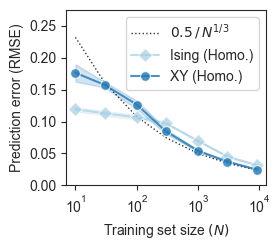

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(2.9, 2.6))

N_list = np.array([10, 30, 100, 300, 1000, 3000, 9000])
Nalpha_list = 0.5 * N_list ** (-1/3)
plt.plot(N_list, Nalpha_list, label=r"$0.5 \, / \, N^{1/3}$", linestyle=':', linewidth=1, c='k', alpha=0.8)
    
df = pd.DataFrame(data=all_data_training_set_scaling, columns=["Training set size", "Model", "Seed", "Error"])
ax = sns.lineplot(data=df[df['Model'] == "Ising (Homogeneous)"], x="Training set size", y="Error", label="Ising (Homo.)", markers=True, marker='D', markersize=7, c='#A6CFE3', alpha=0.7)
ax = sns.lineplot(data=df[df['Model'] == "XY (Homogeneous)"], x="Training set size", y="Error", label="XY (Homo.)", markers=True, marker='o', markersize=7, c='#1F78B4', alpha=0.8)

# plt.plot(list_time, list_of_score_HXY, label='XY (Homogeneous)', linestyle='-', linewidth=1, marker='o', markersize=4, c='#AEDA87', alpha=0.8)
# plt.plot(list_time, list_of_score_HIsing, label='Ising (Homogeneous)', linestyle='-', linewidth=1, marker='D', markersize=4, c='#329D2B', alpha=0.8)
# plt.plot(list_time, list_of_score_DXY, label='XY (Disorder)', linestyle='--', linewidth=1, marker='s', markersize=4, c='#A6CFE3', alpha=0.8)
# plt.plot(list_time, list_of_score_DIsing, label='Ising (Disorder)', linestyle='--', linewidth=1, marker='^', markersize=5, c='#1F78B4', alpha=0.7)

ax.set_xscale('log')
plt.xticks([10, 100, 1000, 10000])
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.ylim(0.0, 0.275)

plt.legend()

plt.xlabel(r'Training set size $(N)$', fontsize=10);
plt.ylabel(r'Prediction error (RMSE)', fontsize=10);
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('SizeN-homogeneous.pdf', dpi=900)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

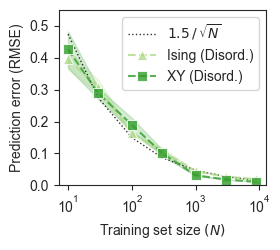

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(2.9, 2.6))

N_list = np.array([10, 30, 100, 300, 1000, 3000, 9000])
Nalpha_list = 1.5 * N_list ** (-1/2)
plt.plot(N_list, Nalpha_list, label=r"$1.5 \, / \, \sqrt{N}$", linestyle=':', linewidth=1, c='k', alpha=0.8)

df = pd.DataFrame(data=all_data_training_set_scaling, columns=["Training set size", "Model", "Seed", "Error"])
ax = sns.lineplot(data=df[df['Model'] == "Ising (Disorder)"], x="Training set size", y="Error", label="Ising (Disord.)", linestyle='--', markers=True, marker='^', markersize=7, c='#AEDA87', alpha=0.8)
ax = sns.lineplot(data=df[df['Model'] == "XY (Disorder)"], x="Training set size", y="Error", label="XY (Disord.)", linestyle='--', markers=True, marker='s', markersize=7, c='#329D2B', alpha=0.8)

ax.set_xscale('log')
plt.xticks([10, 100, 1000, 10000])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim(0, 0.55)

plt.legend()

plt.xlabel(r'Training set size $(N)$', fontsize=10);
plt.ylabel(r'Prediction error (RMSE)', fontsize=10);
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('SizeN-disorder.pdf', d`pi=900)


# Error scaling with evolution time

In [ ]:
# XY model with disordered field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_DXY, list_of_clf_DXY, list_of_bestk_DXY = train_sparse_ML(all_states, all_values)

# XY model with homogeneous field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HXY, list_of_clf_HXY, list_of_bestk_HXY = train_sparse_ML(all_states, all_values)

# Ising model with disordered field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder-Ising/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_DIsing, list_of_clf_DIsing, list_of_bestk_DIsing = train_sparse_ML(all_states, all_values)

# Ising model with homogeneous field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous-Ising/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HIsing, list_of_clf_HIsing, list_of_bestk_HIsing = train_sparse_ML(all_states, all_values)


# Print out the test score
print(list_of_score_DXY)
print(list_of_score_HXY)
print(list_of_score_DIsing)
print(list_of_score_HIsing)

Pos: 0
Validate k = 1
0.1745066879795037
0.17420847094536368
0.1738470293524174
0.17325493951566062
0.1725062346062513
0.17207340105327876
0.1722701178757683
0.17351285603027763
0.17785817715095564
0.18986728242352685
0.21451956568661257
0.28444034100359095
Validate k = 2
0.05029997053056919
0.049277219598439795
0.04873003923300101
0.04871892815854752
0.04949734381174643
0.05235627365232079
0.06209869707095267
0.08538282018945406
0.13026578770534702
0.18750794446431668
0.21475087846753355
0.2846179136509488
Validate k = 3
0.04434950842003946
0.04019379380801462
0.03933884331128232
0.039939456602369264
0.04282791303029935
0.050427667869888934
0.06323373460727437
0.08636344474361739
0.13107481358799666
0.1885163153401796
0.21507639046784977
0.28485777833182163
Scores: 0.03933884331128232 0.007915236382114544
Pos: 1
Validate k = 1
0.19174102703713783
0.19149508574967009
0.19120899696925456
0.19074393405485784
0.1901656442085819
0.18997369486660307
0.19047315430760922
0.19221875414408102
0

0.08976065342793302
0.08995701710664987
0.0911631722059893
0.09566194215927601
0.108935848048338
0.13361255479205297
0.1538201149120686
0.15962376925669342
0.15962376925669342
Validate k = 2
0.06115756896125352
0.06009798400834939
0.05959295338059366
0.059903777034492296
0.06249194445485345
0.06991659509741986
0.08383329907711153
0.10635552462390893
0.13331720433118188
0.15363800613923995
0.15920692035923178
0.15920692035923178
Validate k = 3
0.05973884658725477
0.053885055751481656
0.053007747421609
0.05474441048349358
0.06056643217765898
0.07013929181389807
0.08388689220673425
0.10641835868132203
0.13341804641239233
0.153537242857817
0.15942764067428772
0.15942764067428772
Scores: 0.053007747421609 0.02897388745290167
Pos: 3
Validate k = 1
0.0856787351484311
0.08550897608395346
0.08535524674591481
0.08524458349705398
0.0854933657642194
0.08721495434270052
0.09236524170836802
0.10599014170069593
0.12781261357166476
0.14458044252085547
0.15171290884042057
0.15171290884042057
Validate k

0.21621591925474976
0.2208253449394132
0.23220579494869117
0.2519536442771527
0.31365085154581784
Validate k = 2
0.13368902563273907
0.13227445241138922
0.13090262549620735
0.12948191906096512
0.12902301990672735
0.129975005733206
0.13441962445961486
0.14605288855889256
0.16964377059780503
0.20994179621892867
0.25205024965252254
0.31371755964941633
Validate k = 3
0.07595447805063604
0.06803655479271774
0.06540278373133389
0.06489975300138728
0.06741965759144379
0.0753735940156255
0.09186189052876284
0.11944727712989808
0.16409474012419067
0.20947876119409892
0.2521538913816608
0.31380666594251205
Scores: 0.06489975300138728 0.04902412952128371
Pos: 5
Validate k = 1
0.1790253499700724
0.17877236843722638
0.17847559584336664
0.17799320110222938
0.17738563093958248
0.17712407386600687
0.1775110600003707
0.17938814955389842
0.1856036856373511
0.20138184651146274
0.22576513184249578
0.2767045758393685
Validate k = 2
0.13463816152361266
0.1333227218126064
0.13208361070772726
0.13070948097227

0.07203576157592693
0.07130063930087585
0.07114042714409285
0.07245438146947811
0.07745905682292872
0.08789428620946929
0.09919076114213227
0.10722914091058643
0.11395197846816664
0.1184415650348373
0.1184415650348373
0.1184415650348373
Validate k = 3
0.061971278314808
0.05678323405240021
0.056712223824772826
0.061021296733167515
0.07126882398936431
0.08703671675386747
0.09894242023851196
0.10735668836170748
0.11419561103605329
0.11848053249837172
0.11848053249837172
0.11848053249837172
Scores: 0.056712223824772826 0.035616811446614396
Pos: 7
Validate k = 1
0.09637805252491308
0.09621889061973717
0.0960609917218505
0.09593784653776416
0.09608913061868679
0.09738292619493964
0.1009395640327977
0.10735100757716855
0.1152924354087985
0.12038519030036879
0.12038519030036879
0.12038519030036879
Validate k = 2
0.07018826988859678
0.06945451749505882
0.06926719830546915
0.07041294338623258
0.07479506800809071
0.08376199415904595
0.09669044422727532
0.10709773548782289
0.11518299776736214
0.12

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

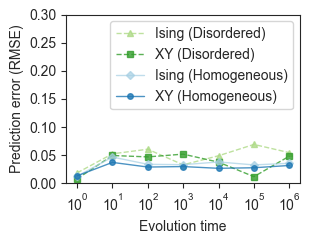

In [ ]:
%matplotlib widget
sns.set_style("ticks")

plot1 = plt.figure(figsize=(3.2, 2.55))

list_of_score_DXY = [0.007915236382114544, 0.04947091105957198, 0.04697752770941811, 0.05191098963262961, 0.03764809304216626, 0.011861222560826395, 0.04830875023735673]
list_of_score_HXY = [0.013256966670524326, 0.03721494102988028, 0.02897388745290167, 0.029803642600065405, 0.026695180719768098, 0.027710837095259566, 0.03173716275137415]
list_of_score_DIsing = [0.018531582079668242, 0.05244811900644047, 0.060618771949532635, 0.032888046159887455, 0.04902412952128371, 0.06912464490177862, 0.054527279125304154]
list_of_score_HIsing = [0.012453854027517147, 0.046725475639309094, 0.033806992302953455, 0.0331672725880195, 0.037965462774408515, 0.032736439079639836, 0.035616811446614396]

list_time = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]
plt.plot(list_time, list_of_score_DIsing, label='Ising (Disordered)', linestyle='--', linewidth=1, marker='^', markersize=5, c='#AEDA87', alpha=0.8)
plt.plot(list_time, list_of_score_DXY, label='XY (Disordered)', linestyle='--', linewidth=1, marker='s', markersize=4, c='#329D2B', alpha=0.8)
plt.plot(list_time, list_of_score_HIsing, label='Ising (Homogeneous)', linestyle='-', linewidth=1, marker='D', markersize=4, c='#A6CFE3', alpha=0.7)
plt.plot(list_time, list_of_score_HXY, label='XY (Homogeneous)', linestyle='-', linewidth=1, marker='o', markersize=4, c='#1F78B4', alpha=0.8)


plt.xscale('log')
plt.ylim(-0.0, 0.3)
plt.xlabel("Evolution time")
plt.ylabel("Prediction error (RMSE)")
plt.xticks(list_time)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('Evo-time.pdf', dpi=900)

# Error scaling with system size

In [ ]:
all_score = []
all_std = []

for N in [10, 20, 30, 40, 50]:
    all_states = []
    all_values = []

    with open("Sys-" + str(N) + "spins-oneZ-allt-homogeneous/states.txt") as f:
        for line in f:
            all_states.append(ast.literal_eval(line))

    with open("Sys-" + str(N) + "spins-oneZ-allt-homogeneous/values.txt") as f:
        for line in f:
            all_values.append(ast.literal_eval(line))

    list_of_score_N, list_of_clf_N, list_of_bestk_N = train_sparse_ML(all_states, all_values)
    
    for v in range(len(all_values[0])):
        all_std.append(np.std(np.array(all_values)[:, v]))
    
    all_score.append(list_of_score_N)

print(all_score)
print(all_std)

Pos: 0
Validate k = 1
0.238658188916499
0.23862582315988756
0.2385856269510222
0.2385147417285325
0.23842415717938636
0.23845712676325623
0.2388304976060893
0.23983326520195264
0.24325637098014205
0.2564810602581238
0.3036492775689448
0.35944222323126346
Validate k = 2
0.07598392678175972
0.0757784830861144
0.07562792437531217
0.07557803716231469
0.07594122945814683
0.07751119797277797
0.08354028307260294
0.09835450264838416
0.1337404815548811
0.22524222682252037
0.3041202360072497
0.3596732477015424
Validate k = 3
0.04318926392701283
0.04251754299816206
0.04243192166326372
0.04296214000700865
0.04502850306483264
0.052450506890268256
0.07121990630617353
0.09794262286467736
0.13344146800321774
0.22507274524425383
0.30473170760382484
0.36033005059357437
Scores: 0.04243192166326372 0.01322497269545254
Pos: 1
Validate k = 1
0.1563651484232806
0.1563328103819973
0.15629689213946396
0.156248357811079
0.1562465556776596
0.15649072730178312
0.15735038436627555
0.16039661492226928
0.17037562799

0.1345120351345599
0.13606572910421444
0.14156499613751533
0.15747853488240854
0.19281488119740592
0.22215476249025767
0.2494300587733484
Validate k = 2
0.06331062659214669
0.06299026868168607
0.06286789850982484
0.06313170342178026
0.06463621621108895
0.06984064475864112
0.08258287989568441
0.11134260573010953
0.15291882655224115
0.1923207349208442
0.22158969597525582
0.2500819573649523
Validate k = 3
0.054367515874000766
0.05273206539524915
0.05245352536648073
0.053893363727626584
0.05863487593991557
0.06902941856530441
0.08240970537637085
0.11130706874428375
0.1533868851716717
0.19287503525790428
0.22198147862559242
0.24985260325385714
Scores: 0.05245352536648073 0.030699445164745386
Pos: 3
Validate k = 1
0.13646868475529736
0.13639335145452033
0.13631183884686643
0.13621383973279994
0.13617992765013437
0.1366067338299901
0.13815130685809096
0.1421103569738252
0.15663283715908677
0.19028951947989617
0.23659568662552966
0.2512290311893053
Validate k = 2
0.09557717750510099
0.09519897

0.16545290669869545
0.21162852025453244
0.21162852025453244
Validate k = 2
0.07052634262933392
0.07003515332079462
0.06975552821386308
0.06995251524911458
0.0718271078571536
0.07767655523610602
0.08942172469250963
0.10886306371185027
0.12855575702962022
0.1653083020618598
0.21182841680805903
0.21182841680805903
Validate k = 3
0.059137248158162015
0.05585093420348794
0.05530278956520735
0.056988778837527114
0.062259576099524094
0.07246120353478827
0.0895030745371978
0.10879868583378162
0.12836481266093458
0.1652597476387852
0.2105604001616631
0.2105604001616631
Scores: 0.05530278956520735 0.032373592811570505
Pos: 5
Validate k = 1
0.11121797431409303
0.11114434447590978
0.11107493302702297
0.11099922861412322
0.11109084214859867
0.11181978844097351
0.11444567121943072
0.12287417648459636
0.1405124449990395
0.1725990955158617
0.2066361906441387
0.21418446837200478
Validate k = 2
0.06783695874645149
0.06726831214213229
0.0669247900471448
0.06705101183703832
0.06886365902291228
0.074801844

0.0669874613612644
0.0662609437073462
0.06589860677194213
0.0661996075405964
0.06854928761550404
0.0751936662471698
0.0878951430057843
0.1028966123116759
0.12553028283081885
0.16067803186317722
0.17264928847702593
0.17264928847702593
Validate k = 3
0.060823480056930515
0.05650015576108855
0.0559284957942369
0.05811779794726258
0.06447954525291624
0.07413569377953282
0.0876633910565133
0.10252878352410529
0.12527707626362725
0.16084274526839182
0.17328403404784118
0.17328403404784118
Scores: 0.0559284957942369 0.03341170415568
Pos: 7
Validate k = 1
0.09112065075982116
0.09099697957381975
0.09088091734901405
0.09076475576126689
0.0909305322322268
0.09226574505148552
0.0969796809203818
0.10930994670798597
0.12776436209232508
0.15422982084090503
0.17016038326858757
0.17016038326858757
Validate k = 2
0.07126293168213321
0.07053423559867847
0.0700994231275634
0.07041322931554043
0.07301153408154566
0.08104291927790949
0.09594197857494435
0.11090411225821271
0.12974863539775755
0.155847080090

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

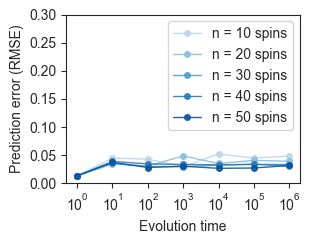

In [ ]:
%matplotlib widget
sns.set_style("ticks")

plot1 = plt.figure(figsize=(3.2, 2.55))

list_time = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

all_score = [[0.01322497269545254, 0.04479558921588049, 0.04292973910856739, 0.029978702246647934, 0.052000697259225445, 0.04494183912184762, 0.048572455160393914], [0.013238151411245697, 0.034490569038691764, 0.030699445164745386, 0.04863870949641657, 0.03528956178937412, 0.04077764991409794, 0.03918693649968483], [0.013327195712980354, 0.03543493750607781, 0.030076289465591825, 0.029608329621221716, 0.032373592811570505, 0.03404159565397256, 0.030068691637193418], [0.012905884564335715, 0.038844056207704196, 0.034592378302616404, 0.03352689516506794, 0.03299109407866409, 0.03360457955846986, 0.03341170415568, 0.03634060633516722], [0.013598927845442432, 0.03730917782077512, 0.028135506651756566, 0.030428638086740904, 0.026699431994580268, 0.027228809474526966, 0.031829182030938936]]

normal_score = []
cnt = 0
for n in range(5):
    ls = []
    for x in range(len(all_score[0])):
        ls.append(all_score[n][x])# / all_std[cnt] * all_std[1])
        cnt += 1
    normal_score.append(ls)
        
plt.plot(list_time, normal_score[0], label='n = 10 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[1], alpha=0.9)
plt.plot(list_time, normal_score[1], label='n = 20 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[2], alpha=0.9)
plt.plot(list_time, normal_score[2], label='n = 30 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[3], alpha=0.9)
plt.plot(list_time, normal_score[3], label='n = 40 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[4], alpha=0.9)
plt.plot(list_time, normal_score[4], label='n = 50 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[5], alpha=0.9)


plt.xscale('log')
plt.ylim(-0.0, 0.3)
plt.xlabel("Evolution time")
plt.ylabel("Prediction error (RMSE)")
plt.xticks(list_time)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('System-size.pdf', dpi=900)

# Visualize predictions

In [ ]:
N = 50
all_states = []
all_values = []

with open("50spins-allZ-many-t-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-allZ-many-t-homogeneous/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HXY_vis, list_of_clf_HXY_vis, list_of_bestk_HXY_vis = train_sparse_ML(all_states, all_values)


Pos: 0
Validate k = 1
0.03689268273717967
0.03675274292002468
0.03664886912476939
0.03658156623204222
0.036586871809294624
0.036704738088962255
0.037173660984349516
0.038995361115104626
0.04556365318375102
0.06556127319996094
0.11483800236226988
0.2207860431827274
Validate k = 2
0.038392774311917344
0.03732879447317554
0.03683958128969139
0.03669763887451952
0.0367133835693784
0.036831630174813466
0.03730043040862338
0.039118647310789276
0.04567201337852763
0.06563887133973546
0.11488489543063538
0.22081361681461384
Validate k = 3
0.04161202543409383
0.03760930523813985
0.03689066720122056
0.036716252316090624
0.036737139040879746
0.03685527705453021
0.03732380520947
0.03914129145394191
0.04569262368795102
0.06565484856047987
0.11489502775616472
0.22081947472432187
Scores: 0.03658156623204222 0.0009405408125936165
Pos: 1
Validate k = 1
0.03675519722112802
0.0365654094995643
0.036437848663498085
0.036354962219892414
0.036368914536195264
0.03648563433012777
0.036950907476662354
0.0387601

0.22033020883487703
Scores: 0.03657365479206852 0.000496574828013811
Pos: 10
Validate k = 1
0.037445432955335936
0.03722003799472906
0.037055939830785894
0.03694863440838593
0.03699316328505334
0.03710925820535313
0.037568120320598176
0.039351730262280525
0.04580024816211099
0.06553504975731657
0.1143877320736827
0.21964571378563452
Validate k = 2
0.03738402236907034
0.03651001148536627
0.036149092129919125
0.03608571707850962
0.036107721302468344
0.03622705590805952
0.036699083524454584
0.03852657297523946
0.04509729814057815
0.06504766400841344
0.1141102743453696
0.21950293086632447
Validate k = 3
0.0419398725269279
0.03762659147731979
0.03675097058351918
0.03653537857246256
0.03653528066215048
0.03665218462949457
0.037117665828414095
0.0389238200675293
0.04543580081294245
0.06528264307209769
0.11424399182482285
0.2195714527456604
Scores: 0.03608571707850962 0.001434735448565573
Pos: 11
Validate k = 1
0.03610827067347703
0.03592954156720837
0.03580722269131499
0.03573243460741532
0.0

0.045586539386757934
0.06543863904350904
0.11445146329264667
0.2199281044675933
Scores: 0.03666489909966095 0.0008234545338927492
Pos: 20
Validate k = 1
0.037226785715511274
0.03701718558855536
0.03689229177749867
0.03682293495794639
0.03683407893098688
0.03694919630625189
0.03740874133288446
0.039198148176573876
0.045668559681518284
0.0654484393894631
0.11435514600882728
0.2196712062166236
Validate k = 2
0.03851217649002356
0.03749542796210574
0.03693026450839387
0.03670640238416526
0.03671778405271704
0.03683454465504166
0.03729778283723578
0.039095600102876896
0.04558346110614379
0.0653909168334651
0.114325806777525
0.2196611307084549
Validate k = 3
0.04137906552082227
0.0372827189345489
0.036342855715820015
0.03607269494099185
0.036081202746598845
0.03619962764198151
0.03667020625139637
0.03849649952845064
0.045070889230009015
0.06503700710320728
0.11412639414219142
0.21955951554932657
Scores: 0.03607269494099185 0.0013713869158947364
Pos: 21
Validate k = 1
0.03759087934259804
0.03

0.03612054739435819
0.03658795418601061
0.03840151249198726
0.044933350759031036
0.06479012779604995
0.11364526709353001
0.21860199609607206
Scores: 0.03598227930986859 0.001005829650237186
Pos: 30
Validate k = 1
0.03665072244539113
0.036475938859354004
0.03635706234979614
0.036281296664218615
0.03629630917012752
0.03641459364547027
0.036882165122346246
0.03869210415248425
0.04520595375970836
0.06502796728457373
0.11387962808769804
0.2189262478154404
Validate k = 2
0.03768872187637434
0.0367646025851716
0.036363062745525754
0.03619237840573679
0.0361962759562504
0.03631382275109747
0.036780781296131736
0.038593119128465844
0.04512100330834912
0.06497229690435524
0.1138507379949105
0.21891260563902915
Validate k = 3
0.041663220209839105
0.03754187859864484
0.03679630274848461
0.03676121202558316
0.03679898307735997
0.03691480850656894
0.03737467508362193
0.0391601963791737
0.04560677781643771
0.0653072010347429
0.11403680129776309
0.2190038890430499
Scores: 0.03619237840573679 0.0010174

0.037229176933136744
0.03701294730486292
0.037027171210157375
0.037143587982360324
0.03760411053638811
0.03939254096160298
0.04585378745863396
0.06561763879864778
0.11453498252948624
0.21993101300801
Scores: 0.03617622422207856 0.0018585494065022972
Pos: 40
Validate k = 1
0.036935681161718366
0.036721636996340026
0.03657381676955739
0.03647826749864575
0.03649528493221877
0.03661308049258907
0.037081428866931
0.03890020805742677
0.04545624910125921
0.06541380542032421
0.11458940112441748
0.22031740949686127
Validate k = 2
0.03795605625360545
0.037030444267568144
0.0365700557075009
0.03643617108527168
0.03644196855535087
0.036560393687984416
0.0370302655372791
0.03885286147283639
0.04541750010092377
0.06538865878068073
0.11457730010811508
0.22031378777839178
Validate k = 3
0.04240295108727723
0.03816597398626676
0.03709785568366143
0.03687244119411366
0.036900977976364956
0.03701805606240877
0.037482460306704296
0.039284748939617566
0.04578921547150128
0.06565048083933223
0.114730409492

0.21941224325268743
Validate k = 3
0.04222419320250746
0.037422406917102524
0.036474395904696325
0.03632022711919261
0.03634623315793483
0.036463774662801096
0.036930795746395434
0.038743862498202386
0.04527840931273842
0.06516763633639142
0.11416696273618453
0.21950741191118495
Scores: 0.03569872261230516 0.0007834082566068979
Pos: 50
Validate k = 1
0.20083692769059447
0.20057549464854224
0.20025126917349176
0.19971304391224703
0.19892584069175537
0.19808955130773662
0.1979582727950784
0.19866141921861333
0.20147507792202896
0.21235970897530065
0.2512282874629672
0.31865642680183703
Validate k = 2
0.04969888452041037
0.04866625861606538
0.04804791524010893
0.047820438637444035
0.04811930802317873
0.049473367407325254
0.05455438019242529
0.0664860572943741
0.09418683806983039
0.16332390089224696
0.25123130259131293
0.31860872994548434
Validate k = 3
0.04494486929620453
0.040385421837772564
0.03938852047851736
0.03935688808212754
0.04023221165255127
0.0436621068196329
0.0548970068490054

0.04765916149306839
0.0430029111432323
0.04227383542732723
0.04259112993396043
0.04463579037395825
0.05214362634101788
0.07111800153953979
0.09835377817403132
0.1331559415536814
0.2235373946625283
0.30491530070947404
0.3617353929161018
Scores: 0.04227383542732723 0.013479308647953447
Pos: 60
Validate k = 1
0.24002494351359666
0.23982437048790872
0.23957573542155947
0.2391480505986413
0.2385892155137402
0.23819215317740533
0.23820852491096442
0.23899046347017777
0.2423195671936077
0.2551904817591984
0.30120919802543245
0.3585198172170562
Validate k = 2
0.08095683452221476
0.07949387018587173
0.07831039572524218
0.07735791582064827
0.07741311462043304
0.0789797656073796
0.08512970322132485
0.09930611766615657
0.13441630848545605
0.22559296271506535
0.30228031133104594
0.3602913636441254
Validate k = 3
0.04905252406347131
0.043892813840704044
0.042799059844318074
0.042961875131061186
0.04496855487750208
0.05239494494614483
0.07192789819916334
0.09914111087797561
0.1342729579333425
0.22547

0.044469283428859196
0.051887291497418365
0.07045953598334058
0.09818643562307479
0.13331789535896518
0.22424739638900243
0.3070344543478867
0.36145764214915754
Scores: 0.04227841571229008 0.013714372407134095
Pos: 70
Validate k = 1
0.24353995100417694
0.24329703898156524
0.24300342943403375
0.24249645072465942
0.24177912918117028
0.24093826356000553
0.24070946530828324
0.24157738536901538
0.2450057353052637
0.2582664150329386
0.3055730198120721
0.3596697293568581
Validate k = 2
0.0791527570796364
0.07795746216655232
0.07704781971942452
0.07632201660236636
0.0764784533454484
0.07804426326204539
0.08405896326524692
0.09816244862122886
0.13367346465616164
0.22539306677384116
0.30650396868174135
0.3599969946804067
Validate k = 3
0.048304600491607536
0.04309522646588001
0.04198581758819527
0.04223519858302364
0.044302030411719304
0.05182162869984966
0.07052011602861152
0.09757660167364776
0.1332427911401463
0.22513481219133696
0.3057219812737617
0.3593862390376696
Scores: 0.041985817588195

0.09727961875839884
0.13224491702218766
0.2227003453535714
0.3033394535286457
0.36192689183921345
Scores: 0.04262215478499505 0.013741913024865732
Pos: 80
Validate k = 1
0.2394844760212428
0.23923833085375712
0.23894315507196703
0.23845252309199197
0.2377489528015402
0.23715328422247084
0.23730973220204735
0.23829435845809288
0.24169270582327812
0.25483860284083615
0.301650171194762
0.3577641103463346
Validate k = 2
0.07964002184430512
0.07823812604019825
0.07711634887440214
0.0762817325724486
0.07630210056853048
0.07786429547417933
0.08407577471258922
0.09938942884519386
0.13524765768995212
0.2279056998432485
0.30214701780623276
0.3584950227152015
Validate k = 3
0.04778449109896502
0.04290660817569336
0.042000571345433446
0.04240393972172849
0.04446706993986705
0.05187968217889991
0.07026080078443593
0.09908551761466844
0.1350227928787669
0.22777334640445657
0.3019280897459458
0.35822818263394907
Scores: 0.042000571345433446 0.013912538825036142
Pos: 81
Validate k = 1
0.23947098159020

0.3029956074868765
0.3589912180313416
Scores: 0.042859582664091345 0.013217831035132193
Pos: 90
Validate k = 1
0.24473068668396397
0.24453666118535114
0.24430841390127916
0.24393595836268298
0.24340326177381083
0.2428161081670624
0.24288532898036894
0.2437589762962162
0.24705000535668772
0.25980471540908945
0.3055543399541778
0.36322262887391
Validate k = 2
0.07889600122337631
0.07750834413253016
0.07637253204836034
0.07546974461686527
0.07556161554292438
0.07712409299325726
0.08325874565207769
0.09734603193048302
0.13174111189337287
0.22106308946287126
0.305663675893828
0.363287085036366
Validate k = 3
0.04794121472335979
0.04350876263575419
0.04245668674037551
0.04260023907877216
0.04461464823761345
0.05208116405468974
0.07107877123546023
0.09795106495274455
0.13218029287889616
0.2213193211295912
0.3062548663307189
0.36375187343196225
Scores: 0.04245668674037551 0.013632622900303178
Pos: 91
Validate k = 1
0.2410255862461102
0.24082955461677297
0.24059076286609105
0.2401823647375105
0

0.24729889644584807
0.2470609512964348
0.24676231281481412
0.24624349777730792
0.24546542091654194
0.24466791592001555
0.244576270693419
0.24582553358176742
0.25013888342309054
0.26675024907671285
0.303512908529823
0.3861315052088435
Validate k = 2
0.10292819735695388
0.10143285937871768
0.10011617172464111
0.09872954131861413
0.09825981790595513
0.09951076484650404
0.10451588818215496
0.11953953181977447
0.16278432479967606
0.24292009182405405
0.30360987094379754
0.386240741252018
Validate k = 3
0.057632826118379145
0.0514675128444264
0.04977299071818503
0.04984981430335177
0.0520283925553177
0.058758219391611216
0.07748756871174343
0.1185618579117052
0.16228809332180136
0.2426659368628634
0.30345449298034055
0.3864747985671974
Scores: 0.04977299071818503 0.027785118954598186
Pos: 101
Validate k = 1
0.19153074732876452
0.19127063652510873
0.1909539650399985
0.19042169426298106
0.18974313168976578
0.18927600213771073
0.18971378916782972
0.19186978623317144
0.19971742528438297
0.2225884

0.1717427102975362
0.1827001982459363
0.21669836950372764
0.27009480958363596
0.2701061220991968
Validate k = 2
0.101758373335507
0.10042081022335599
0.09926002402755191
0.09830140301988534
0.09861785928817896
0.10165236903367034
0.11052758351111984
0.13007346638847797
0.17939342916380013
0.21656304684963926
0.27031213792420644
0.27031213792420644
Validate k = 3
0.07853305269656266
0.07020323973618053
0.06708264584966792
0.06662125350687824
0.06990414866850754
0.08044294218826488
0.10404529139674079
0.13063130964886274
0.17949942385780018
0.21645551913978026
0.2702816565226279
0.2702816565226279
Scores: 0.06662125350687824 0.04908080176600455
Pos: 111
Validate k = 1
0.16779591432550806
0.16756529841762163
0.16728699949398065
0.16684968369382275
0.16635800330675593
0.1662138463017749
0.1671017183398285
0.17028780092123869
0.18123642263481785
0.2144300005681234
0.272671129374199
0.27471293033904987
Validate k = 2
0.101753385523433
0.10045538699254922
0.09932921510073282
0.098403068527692

0.1004839884487927
0.09931944975971256
0.09838548890008278
0.09776589888436142
0.09819285005491027
0.10104536262574815
0.10917141269808474
0.12773147821020578
0.17596292979621578
0.2171995453003889
0.2752245723830171
0.2765661084025408
Validate k = 3
0.07531352427794452
0.06767112870583161
0.06550893322134659
0.06567056169694488
0.06916477457428458
0.0799251455718382
0.10269389054549552
0.12774413980815597
0.17686547837524794
0.2177433391743276
0.27589660137199884
0.2774052861400435
Scores: 0.06550893322134659 0.04872448925826793
Pos: 121
Validate k = 1
0.17030506530019213
0.17007244979562294
0.16979566447828096
0.16935955635457262
0.16881069745039579
0.16852391254432583
0.16936740765690259
0.17261873501843616
0.18341134549879104
0.21816689856568047
0.2755756975845047
0.2763258243696201
Validate k = 2
0.09909726154447272
0.0977581677997586
0.09659585089034245
0.0956438489363317
0.09599291476840868
0.09908587205472583
0.10738792785876827
0.12699814546241345
0.17532844272341208
0.2180113

0.0969572077918731
0.09982088090239383
0.10887127336453489
0.12815870314192734
0.17658161418379836
0.21570519071901356
0.2732026997631272
0.2732026997631272
Validate k = 3
0.07620445477308027
0.06853685732174462
0.06601582716887429
0.0659035988902186
0.06903415330454646
0.07925644332672924
0.10322663803808084
0.1293310938802679
0.17769456642765752
0.21584587896545998
0.27380786920101735
0.27385901145684743
Scores: 0.0659035988902186 0.05029752491571697
Pos: 131
Validate k = 1
0.172624235449515
0.17240238289381998
0.1721504200866442
0.17175563077287453
0.17129706475322715
0.17107977284992673
0.17183307496818004
0.1747848111161785
0.18539117915010056
0.21953272023850803
0.2767883282628888
0.2780330858814891
Validate k = 2
0.10328239924819409
0.10188847981997401
0.10069295900677397
0.09968230806528755
0.0999603602187987
0.1028267961033404
0.11071647094744985
0.1284288875649452
0.1757585149039208
0.21942686794995936
0.2768814067650217
0.27791834791121106
Validate k = 3
0.07566462942306104


0.21671985609175615
0.27495384790392263
0.2755938437735577
Validate k = 3
0.07665707140535677
0.06871010930311348
0.06614210369679142
0.06612418343746891
0.06931178414583812
0.07980929525502953
0.10293928916845901
0.1283534738037915
0.17640521745821153
0.2167713724961213
0.27480010710032554
0.2753051277059898
Scores: 0.06612418343746891 0.0503608788878308
Pos: 141
Validate k = 1
0.16916531052887915
0.1689302447292083
0.16865260929472461
0.16819623244467546
0.16763364522411828
0.16731808037728868
0.168106111852014
0.1711137812184743
0.18193259536632755
0.21590590283940822
0.27269810936047706
0.27380837780571343
Validate k = 2
0.10211458501005571
0.1007127694315033
0.09950162472855999
0.09854160807748061
0.09890365997211631
0.10180341251906627
0.1108308837932737
0.1299257958444339
0.17807947035787053
0.2163753328038396
0.2725656221632968
0.27378937507864354
Validate k = 3
0.07567230827024973
0.06783656713463188
0.06522012182271494
0.06501711023090008
0.06821408134662718
0.078776629697716

0.06537597794859443
0.06308336835022882
0.06280513727610967
0.06538550218185069
0.07392363801474841
0.09566835779070477
0.13349234008100958
0.18152769114227743
0.24647268136792197
0.2924547787238208
0.33266670858734926
Scores: 0.06280513727610967 0.04558171806135781
Pos: 151
Validate k = 1
0.18848788680572126
0.1882641633762216
0.1879863589511864
0.18752699550199056
0.1868752348274646
0.18641427967031332
0.18711632608100756
0.1904021864884275
0.20105813067961695
0.22254858419335766
0.25940968941354237
0.31201318427465424
Validate k = 2
0.0961634204744275
0.09475042063583192
0.09358829356171383
0.09261226307185516
0.0929126786883505
0.0961039804507256
0.10572596426336907
0.12916699193812708
0.16293098093214392
0.22019468438120482
0.2596309083201283
0.31250304126974193
Validate k = 3
0.07678072989714041
0.06933905948008623
0.06694989920927799
0.06669646750074613
0.07015563310818716
0.08060777467899197
0.10018403276833937
0.12872259065708935
0.1624824063929365
0.21960362686993073
0.258927

0.05930005160050598
0.06498966001693605
0.0807106540568589
0.0980518977317264
0.12964189656708003
0.16064801509067184
0.19075172495205306
0.1940802932176775
0.1940802932176775
Scores: 0.05841426107438407 0.037724219826655844
Pos: 161
Validate k = 1
0.12563275957826828
0.12543800594159554
0.1252212326142591
0.12489774748511268
0.12460674476516416
0.12488552102194686
0.12712638790764455
0.1354282235022921
0.1616101778865538
0.1918050293871674
0.194581285163055
0.194581285163055
Validate k = 2
0.08151683944098963
0.08026086409807888
0.07931937983911402
0.07885174123859207
0.08026134529846503
0.08498988783874059
0.09815188250620971
0.12932605816809206
0.1615888211502728
0.19200421974977727
0.19458035904577936
0.19458035904577936
Validate k = 3
0.06713860546592525
0.060683991618351016
0.0587787697609174
0.05966268528236804
0.06553540306965487
0.08220413379888318
0.09893617918820753
0.12956411524083072
0.16191513322814063
0.19228584387126949
0.19478638420784838
0.19478638420784838
Scores: 0.

0.0813666868421812
0.09743449091930129
0.1281487841191768
0.16074738512060927
0.1913611330515511
0.19451640609164692
0.19451640609164692
Scores: 0.058038831170996494 0.03701859150263433
Pos: 171
Validate k = 1
0.12513885275497122
0.12490768585559262
0.12465445295512537
0.12427751060819578
0.12403235441269607
0.1245167897307548
0.12682432174359193
0.1348284721077287
0.16123742126239016
0.19059926720571332
0.1929905206012673
0.1929905206012673
Validate k = 2
0.081009984998672
0.0798386134595896
0.07895226464652717
0.07857953242616558
0.08004340183258693
0.08495543006064599
0.09838166973135382
0.12811175580479792
0.16150803981950987
0.1909938987262219
0.19339905168557253
0.19339905168557253
Validate k = 3
0.06633602716068399
0.059492341675714176
0.057612520612621745
0.05851061253113789
0.06468451546116509
0.08085441567598775
0.09820301396087594
0.12796266624681013
0.16123038274267507
0.19046522234786997
0.1927650762565319
0.1927650762565319
Scores: 0.057612520612621745 0.03678316818767636

0.16064077620465866
0.1900117444465529
0.1932065697348338
0.1932065697348338
Scores: 0.05818596793255761 0.037178534770541116
Pos: 181
Validate k = 1
0.12673968811677852
0.1265463985783895
0.12633168469196512
0.12603425436388532
0.12578696013465318
0.12610306259684548
0.1283424850834169
0.13610804805499482
0.16194620640411322
0.19258866036337977
0.19692199210180647
0.19692199210180647
Validate k = 2
0.08211531609853978
0.08101188802109377
0.0802223234933311
0.0799011291890157
0.08124240172673461
0.0859544014041426
0.09851289627591095
0.12887038309283563
0.16236256714620495
0.19280631786130817
0.197278519620342
0.197278519620342
Validate k = 3
0.0656193670325486
0.05935364785551367
0.058017475842187416
0.059079432091538875
0.06490599884701212
0.08113320383042699
0.09827768954612308
0.1278133691891353
0.16149847703801934
0.19274724429314682
0.19722106792898506
0.19722106792898506
Scores: 0.058017475842187416 0.03672998933092356
Pos: 182
Validate k = 1
0.12617632716698035
0.12598939837604

0.2048324024763109
Scores: 0.05600677211908836 0.03442740127672078
Pos: 191
Validate k = 1
0.10622874758561603
0.10604209901035622
0.10584077546670283
0.10559149868329186
0.10553867774646325
0.10614695165863211
0.10835062152786452
0.11579501641672138
0.1401457439289211
0.17096022578558057
0.19624091675784233
0.22992442257842077
Validate k = 2
0.07614880115109446
0.07492198959390475
0.07412388478484475
0.07405794640685995
0.07575253700125581
0.07975895378398593
0.09035246123870194
0.1136844576874411
0.14106387583698116
0.1712260443166211
0.1966001079515459
0.22958606185430994
Validate k = 3
0.06679065303090911
0.05997034996638501
0.05817944539133185
0.058876864193085104
0.06380912005197914
0.07596679853234015
0.08892453285439532
0.11230949665278393
0.13943991504960818
0.16956353707760147
0.19498478684786028
0.2278038519974771
Scores: 0.05817944539133185 0.03950605853183574
Pos: 192
Validate k = 1
0.11949637935563115
0.11927850503235282
0.11904721630355057
0.11872535733408915
0.118527354

0.09129039603991479
0.0910876386471434
0.09088586839347622
0.09068737961654205
0.09092352866531665
0.0924813871510897
0.09735591070718633
0.109887387001066
0.1355918878963286
0.15108563241992717
0.15108563241992717
0.15108563241992717
Validate k = 2
0.06646530565376257
0.06550550254557694
0.064953025349833
0.06525044146094411
0.06824032551621508
0.07706624032142191
0.09245961219872618
0.1099732645525115
0.13600083555285888
0.15135224153299467
0.15135224153299467
0.15135224153299467
Validate k = 3
0.061252410476340884
0.05521340174526772
0.05435519506989449
0.056509216260366195
0.0631037032259906
0.07666931778665732
0.09234002342118547
0.1096931943386766
0.13582392643446634
0.15074504417199336
0.15074504417199336
0.15074504417199336
Scores: 0.05435519506989449 0.031079408172951472
Pos: 202
Validate k = 1
0.09211379519172157
0.09195529943560257
0.09180352807067675
0.09168774447819147
0.09189831431021321
0.09339031831732322
0.0983431067146474
0.11290808045749315
0.13629974417241086
0.1456

0.08180394746929119
0.08209337607034867
0.08358173598487975
0.08816939252269632
0.1012352958390017
0.12507798807168224
0.15329120073082095
0.1624527710182351
0.1624527710182351
Validate k = 2
0.06743710680526471
0.0665133714979925
0.06601801337699845
0.06633171971419721
0.06880544376789885
0.07511250673980362
0.084906747444812
0.10128567656113975
0.1252044292948312
0.15348548072784046
0.16281851382103374
0.16281851382103374
Validate k = 3
0.059278174833760196
0.05374243571121972
0.0528905981099546
0.054813043573047206
0.06085884875098518
0.07143660474702129
0.08459581797656147
0.10081718546852486
0.12411401205977747
0.15236286263900908
0.1619216196147982
0.1619216196147982
Scores: 0.0528905981099546 0.028766369570653406
Pos: 212
Validate k = 1
0.09367781439541095
0.09348648038764978
0.09329632272185658
0.0930909001703444
0.09324446875439671
0.0946334494923578
0.09889870944410234
0.11082468904874543
0.13338466262438448
0.14937345908543925
0.1678618778855259
0.1678618778855259
Validate k

0.10237719855528456
0.12601715088154908
0.15869168363237499
0.1640870467997409
0.1640870467997409
Validate k = 2
0.06441795380606911
0.06326789894262248
0.0625848171413031
0.06278683665818321
0.06512493713773926
0.07192117842421619
0.08596921806945783
0.10250264714594634
0.12596965153150078
0.1585129566505861
0.16454056964578545
0.16454056964578545
Validate k = 3
0.06165976024679927
0.055743104413328526
0.05431829370292389
0.05534861285132833
0.060347134063413965
0.07081154849719402
0.08600669576951528
0.102455948740479
0.1257850084599891
0.15910535235180415
0.16490760450259573
0.16490760450259573
Scores: 0.05431829370292389 0.0319415230202651
Pos: 222
Validate k = 1
0.0856002360084075
0.0854226589655101
0.08526605762048975
0.08512946238148161
0.08540413235595132
0.08708750082630513
0.09174933165611943
0.10299343233461257
0.12436619520855632
0.1550122243827652
0.15753974428965944
0.15753974428965944
Validate k = 2
0.06799007008023897
0.06699674654892535
0.06645443149069227
0.0668854591

0.06373556261984617
0.06286263918599834
0.062484965354654955
0.06297511764973501
0.06572831141453939
0.07211640352626446
0.08579725974972126
0.1063566029820554
0.1291295278238986
0.15479396464237102
0.15496395113250439
0.15496395113250439
Validate k = 3
0.06278838046583893
0.057022008258205324
0.05621092165084392
0.05815147889699022
0.06291623631669482
0.07078252905187532
0.08526390275713594
0.10519360769371393
0.12864504309072233
0.15456099615074995
0.15474430008711523
0.15474430008711523
Scores: 0.05621092165084392 0.033868086191994495
Pos: 232
Validate k = 1
0.08620840747154696
0.0860420979951772
0.08589430775943718
0.08578370841708417
0.08609387860825875
0.08779351998144506
0.09298053562308692
0.10582969909043242
0.1269427920993379
0.14351233437731792
0.1502886058273989
0.1502886058273989
Validate k = 2
0.06459827866152434
0.06366882540393227
0.06327467639777341
0.0639519252372744
0.06736385264025561
0.07695557960558849
0.0919833188321197
0.10549316084752335
0.1270131286646432
0.14

0.06332641985610667
0.0639012276834898
0.06718247219144785
0.07511863489920823
0.08733843263792854
0.10107747915885916
0.12625287813529007
0.14452179411775323
0.1583118917391836
0.1583118917391836
Validate k = 3
0.06214976285008892
0.05639378421984741
0.05533715459801
0.05752553662555061
0.06424826251465832
0.07433801153152747
0.08718594056038739
0.1010126236617198
0.12634135156674903
0.1444983845316338
0.15856167597293688
0.15856167597293688
Scores: 0.05533715459801 0.03157086007811973
Pos: 242
Validate k = 1
0.09047808279258043
0.09034480842345434
0.09023051420195138
0.09016183525054634
0.090441005660952
0.09196902795958817
0.09672551504488122
0.10884611022737965
0.12941122314050407
0.14528686751215703
0.16611465546085896
0.16611465546085896
Validate k = 2
0.06915738575492314
0.06815802348628552
0.06758702452011686
0.06791027526076858
0.07071652669067942
0.07879823406768632
0.09217258632695902
0.10857261098085938
0.1292352792211147
0.14528850020044146
0.16596717683270876
0.1659671768

0.06343908266979506
0.07187025752559568
0.08453633663935023
0.10333740924091288
0.12112963416701376
0.148544332759124
0.1730522462926269
0.1730522462926269
Validate k = 3
0.060503077004826634
0.054536496485056284
0.053731720423225104
0.05592090084589718
0.06156367024214653
0.07152817921737882
0.08382323684445843
0.10300310555211634
0.12046525779381854
0.1477376057833435
0.1719876418311862
0.1719876418311862
Scores: 0.053731720423225104 0.030196289011284225
Pos: 252
Validate k = 1
0.0939544313837404
0.09377971746248648
0.09360894920006634
0.09344400533080675
0.0935757578057784
0.09492929236591886
0.10003252366545501
0.11220298542726442
0.13761625756255685
0.1531082615368482
0.1531082615368482
0.1531082615368482
Validate k = 2
0.06345515884184635
0.06252411083604582
0.06210590387663329
0.06262578562491965
0.06547368811077406
0.07375447156146087
0.09091493539768904
0.11196914788363874
0.1380235208923872
0.15322120299054476
0.15322120299054476
0.15322120299054476
Validate k = 3
0.057942701

0.092441069743535
0.11109022726091657
0.13237674250395476
0.15015571334615002
0.1517533311141592
0.1517533311141592
Validate k = 3
0.061748474754950225
0.05602538434118285
0.055171223513351145
0.05751158107054482
0.06487502798355946
0.07792302110998452
0.09156723250629112
0.10990499783895219
0.13164471621139673
0.14943412428302
0.1508131173636287
0.1508131173636287
Scores: 0.055171223513351145 0.032097457545450306
Pos: 262
Validate k = 1
0.09352868780205245
0.09331317665879281
0.09308751319540676
0.0928402517232467
0.09291483731570259
0.09415907234189105
0.09821560578836327
0.10931122322943795
0.12779659528907852
0.1535313747298869
0.17997645770269946
0.17997645770269946
Validate k = 2
0.061564392188822745
0.06058521669761522
0.06015714291116074
0.06066868726065036
0.06356086508533157
0.0709396464501276
0.0824891852170063
0.10117246525859579
0.12794854716104842
0.15321790681733155
0.1801757602442591
0.1801757602442591
Validate k = 3
0.06125888412659673
0.055616123402077736
0.0547875454

0.12679669102281685
0.15842628355235577
0.175262209488795
0.175262209488795
Validate k = 3
0.060431196558649966
0.054449348844771386
0.05344932290532933
0.05525769097507982
0.060784079783193015
0.06873422625948099
0.08073543788265311
0.09983322699739891
0.12659446603916752
0.15810387167901782
0.1747604880398847
0.1747604880398847
Scores: 0.05344932290532933 0.029398295482265517
Pos: 272
Validate k = 1
0.08922243496061609
0.08905370405986322
0.08889677087331364
0.08874976003615119
0.08888661119213004
0.09017652841933915
0.09439058685922172
0.10548140858580989
0.1248958010735153
0.15099413449416552
0.18077768108618344
0.18275761678328423
Validate k = 2
0.06172444949196425
0.06075430957210376
0.06027807205297717
0.060673487695218575
0.0630404186513926
0.06928836505029398
0.08291691042390667
0.10500701643967393
0.12550601561723554
0.15132840205971437
0.18101340606160168
0.1833624297765716
Validate k = 3
0.060434277810132504
0.054588963313298856
0.05371344212931344
0.055543958368396505
0.06

0.14987934782399132
0.17177718550812338
0.17177718550812338
Validate k = 3
0.0615243082435374
0.055916252426479934
0.054968331618979946
0.05656971494040619
0.06184342818271225
0.07103855467696822
0.08213337022299132
0.09661089486658174
0.1156646468294002
0.151035182871528
0.17192651970743836
0.17192651970743836
Scores: 0.054968331618979946 0.03019868005144769
Pos: 282
Validate k = 1
0.08972651044745439
0.08955280568049914
0.08937094740179642
0.0891606923965128
0.08931757500161941
0.09060236839805594
0.0953595918374068
0.10826439502465024
0.12876771835859008
0.15387143156574162
0.15401909254653134
0.15401909254653134
Validate k = 2
0.065830794587147
0.06467533863724964
0.06408274351631589
0.06457481101736863
0.0675267027696969
0.07540233547958697
0.08849186869012077
0.10797657089771383
0.12871751371222875
0.1537962455739444
0.15393316229219717
0.15393316229219717
Validate k = 3
0.059888279608490726
0.05425645170871859
0.05356289362673487
0.05596541947928645
0.06312430102705306
0.0745203

0.15390370201256004
0.1694767221078474
0.1694767221078474
Validate k = 3
0.060434058405153035
0.05469910681618454
0.05385507506055335
0.05597989000748761
0.06268306316856505
0.0733332038591118
0.08782603600612365
0.10349043135374576
0.12359351189900772
0.153691045388406
0.1696108431995798
0.1696108431995798
Scores: 0.05385507506055335 0.029947990685602693
Pos: 292
Validate k = 1
0.08438022512837759
0.08422610967306815
0.08408820986080462
0.08400817370996472
0.0843320677749978
0.08589824160916078
0.09086057427445289
0.10256677292967828
0.12450861292393332
0.15479408199125722
0.16046929191990034
0.16046929191990034
Validate k = 2
0.060823575498647725
0.059961149248107484
0.059586042001707674
0.06016570044413962
0.06328073295943334
0.07151574568643775
0.08552169596943313
0.10239318684231516
0.12423816262082049
0.15483213423223732
0.16023168449542124
0.16023168449542124
Validate k = 3
0.06221693472004752
0.05618599176505633
0.05500798645731466
0.056894419311677366
0.06252744532462073
0.072

In [ ]:
# Pickle dump
pickle.dump( list_of_score_HXY_vis, open( "list_of_score_HXY_vis.p", "wb" ) )
pickle.dump( list_of_clf_HXY_vis, open( "list_of_clf_HXY_vis.p", "wb" ) )
pickle.dump( list_of_bestk_HXY_vis, open( "list_of_bestk_HXY_vis.p", "wb" ) )

In [ ]:
# Pickle load
list_of_score_HXY_vis_pkl = pickle.load( open( "list_of_score_HXY_vis.p", "rb" ) )
list_of_clf_HXY_vis_pkl = pickle.load( open( "list_of_clf_HXY_vis.p", "rb" ) )
list_of_bestk_HXY_vis_pkl = pickle.load( open( "list_of_bestk_HXY_vis.p", "rb" ) )

In [ ]:
# Pickle load (just to be safe)
list_of_score_HXY_vis, list_of_clf_HXY_vis, list_of_bestk_HXY_vis = list_of_score_HXY_vis_pkl, list_of_clf_HXY_vis_pkl, list_of_bestk_HXY_vis_pkl

300


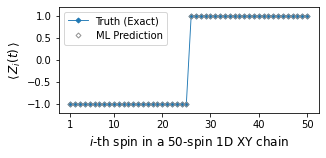

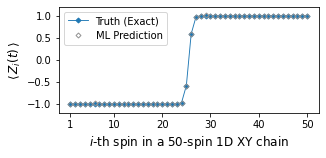

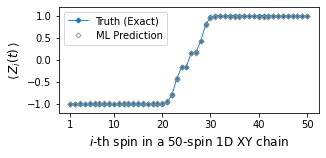

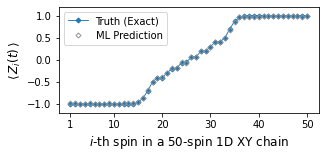

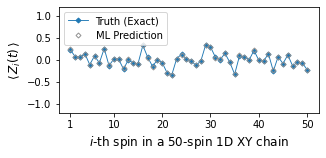

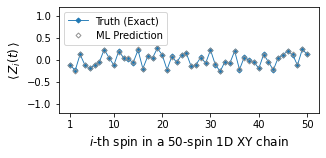

In [ ]:
# Visualize half-half state

N = 50

def get_feat_vec_half_half(k):
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val = 0.0
                
                if (i+c) < N / 2: val *= -1
                else: val *= +1
                    
            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
true_ans = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999988,-0.999222,-0.972817,-0.585528,0.585528,0.972817,0.999222,0.999988,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999998,-0.999966,-0.999505,-0.994686,-0.959792,-0.801725,-0.43163,-0.166451,-0.157728,0.157728,0.166451,0.43163,0.801725,0.959792,0.994686,0.999505,0.999966,0.999998,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999999,-0.999995,-0.999954,-0.999668,-0.997989,-0.989958,-0.959642,-0.873541,-0.703182,-0.501119,-0.407192,-0.406774,-0.297204,-0.200754,-0.193937,-0.0642642,-0.0604844,0.0604844,0.0642642,0.193937,0.200754,0.297204,0.406774,0.407192,0.501119,0.703182,0.873541,0.959642,0.989958,0.997989,0.999668,0.999954,0.999995,0.999999,1,1,1,1,1,1,1,1,0.223538,0.0704778,0.0547808,0.137909,-0.109168,0.0870547,-0.0704109,0.255476,-0.132473,0.0208235,0.0104076,-0.210476,0.00149826,-0.0734874,-0.0874279,0.326401,0.0580026,-0.146868,-0.00298605,-0.0620534,-0.292064,-0.337162,0.0267581,0.126973,0.0217619,-0.0217619,-0.126973,-0.0267581,0.337162,0.292064,0.0620534,0.00298605,0.146868,-0.0580026,-0.326401,0.0874279,0.0734874,-0.00149826,0.210476,-0.0104076,-0.0208235,0.132473,-0.255476,0.0704109,-0.0870547,0.109168,-0.137909,-0.0547808,-0.0704778,-0.223538,-0.122712,-0.239076,0.121464,-0.116011,-0.195256,-0.1169,-0.0462604,0.231811,0.0477476,-0.121555,0.194615,0.0496414,0.0103274,-0.0615695,0.220349,-0.198141,0.0778494,0.041073,0.261736,0.111922,-0.222931,0.0772192,-0.0577005,0.108646,0.147718,-0.147718,-0.108646,0.0577005,-0.0772192,0.222931,-0.111922,-0.261736,-0.041073,-0.0778494,0.198141,-0.220349,0.0615695,-0.0103274,-0.0496414,-0.194615,0.121555,-0.0477476,-0.231811,0.0462604,0.1169,0.195256,0.116011,-0.121464,0.239076,0.122712,]).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_half_half(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.2, 1.2])
#     plt.title(r"$| 111 \ldots 000 \rangle$" + r" at time $t = {}$".format(evo_time_list[i]))

    plt.tight_layout()
    plt.savefig('111000-allZ-{}.pdf'.format(i), dpi=900)
    

300


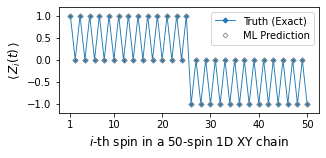

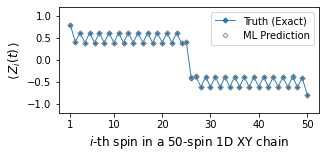

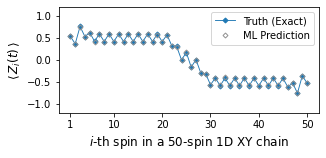

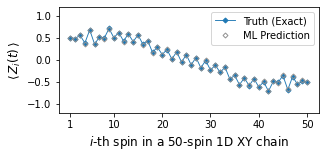

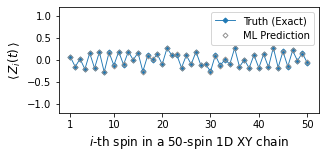

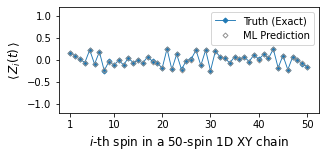

In [ ]:
# Visualize entangled Neel state

N = 50

def get_feat_vec_GHZ_Neel(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val1 = 0.0
                
                if (i+c) % 2 == 1: val1 *= -1
                else: val1 *= +1

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val2 = 0.0
                
                if (i+c) >= N / 2: val2 *= -1
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
true_ans = np.array([1,-3.33067e-16,1,-3.33067e-16,1,0,1,2.22045e-16,1,2.22045e-16,1,2.22045e-16,1,0,1,-1.11022e-16,1,0,1,-2.22045e-16,1,-1.11022e-16,1,0,1,-1,-6.66134e-16,-1,-2.22045e-16,-1,0,-1,-4.44089e-16,-1,-2.22045e-16,-1,-1.11022e-16,-1,-1.11022e-16,-1,0,-1,2.22045e-16,-1,2.22045e-16,-1,2.22045e-16,-1,2.22045e-16,-1,0.788362,0.405052,0.612547,0.388066,0.611946,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388048,0.611556,0.374463,0.404709,-0.404709,-0.374463,-0.611556,-0.388048,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611946,-0.388066,-0.612547,-0.405052,-0.788362,0.52933,0.361496,0.754613,0.525902,0.616209,0.418987,0.586335,0.414214,0.585828,0.414175,0.585825,0.414175,0.585825,0.414175,0.585825,0.414175,0.585824,0.414157,0.585578,0.411518,0.565721,0.315037,0.30164,-0.0025997,0.164689,-0.164689,0.0025997,-0.30164,-0.315037,-0.565721,-0.411518,-0.585578,-0.414157,-0.585824,-0.414175,-0.585825,-0.414175,-0.585825,-0.414175,-0.585825,-0.414175,-0.585828,-0.414214,-0.586335,-0.418987,-0.616209,-0.525902,-0.754613,-0.361496,-0.52933,0.503342,0.481823,0.555969,0.379553,0.676754,0.356992,0.510313,0.489078,0.709057,0.498859,0.617281,0.426286,0.584769,0.411879,0.563395,0.353266,0.435104,0.167047,0.287108,0.119875,0.232115,0.0168645,0.180481,-0.0513803,0.113755,-0.113755,0.0513803,-0.180481,-0.0168645,-0.232115,-0.119875,-0.287108,-0.167047,-0.435104,-0.353266,-0.563395,-0.411879,-0.584769,-0.426286,-0.617281,-0.498859,-0.709057,-0.489078,-0.510313,-0.356992,-0.676754,-0.379553,-0.555969,-0.481823,-0.503342,0.0641132,-0.156605,0.0212648,-0.211451,0.151916,-0.189812,0.176076,-0.276748,0.165638,-0.124994,0.182763,-0.109042,0.187432,-0.002042,0.159606,-0.263859,0.097639,-0.00387948,0.12612,-0.103179,0.263876,0.102068,0.119708,-0.18066,0.101832,-0.101832,0.18066,-0.119708,-0.102068,-0.263876,0.103179,-0.12612,0.00387948,-0.097639,0.263859,-0.159606,0.002042,-0.187432,0.109042,-0.182763,0.124994,-0.165638,0.276748,-0.176076,0.189812,-0.151916,0.211451,-0.0212648,0.156605,-0.0641132,0.15872,0.084307,0.00893069,-0.0615725,0.223252,-0.0967308,0.182103,-0.244717,-0.0320069,-0.122955,-0.0108487,-0.115121,0.0397093,-0.0642493,-0.0126599,-0.0731859,0.0733459,-0.0360828,-0.0679437,-0.190291,0.248513,-0.218302,0.125698,-0.218771,-0.016088,0.016088,0.218771,-0.125698,0.218302,-0.248513,0.190291,0.0679437,0.0360828,-0.0733459,0.0731859,0.0126599,0.0642493,-0.0397093,0.115121,0.0108487,0.122955,0.0320069,0.244717,-0.182103,0.0967308,-0.223252,0.0615725,-0.00893069,-0.084307,-0.15872,]).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_GHZ_Neel(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.2, 1.2])
#     plt.title(r"$\frac{1}{\sqrt{2}} | uu \ldots dd \rangle + \frac{1}{\sqrt{2}}| udud \ldots \rangle$" + r" at time $t = {}$".format(evo_time_list[i]))

    plt.tight_layout()
    plt.savefig('Neel-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

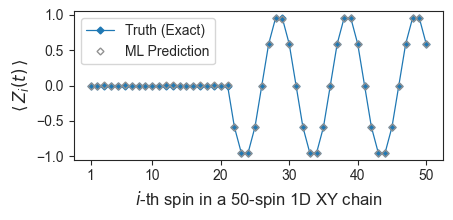

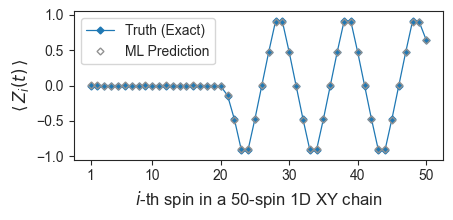

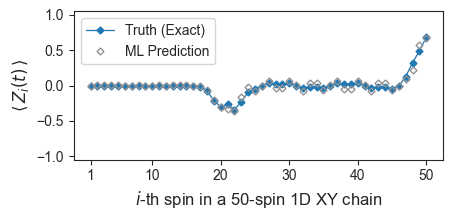

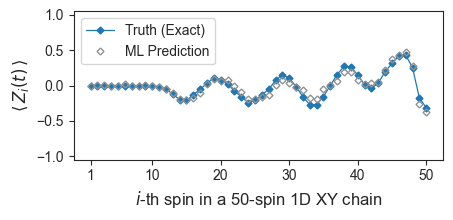

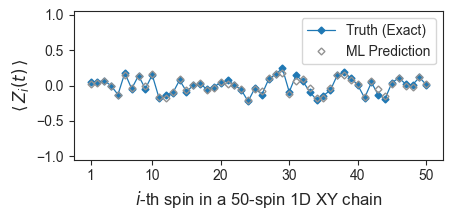

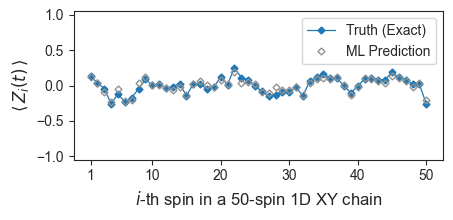

In [ ]:
# Visualize W state

N = 50
scale = 3.0

def get_feat_vec_Entangled(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < 20:
                    if P != 0: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - 20)) / 30
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < 20:
                    if P != 0: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - 20)) / 30
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [-1.33227e-15,-9.99201e-16,-5.55112e-16,-1.11022e-15,-2.22045e-16,-6.66134e-16,-3.33067e-16,-5.55112e-16,-4.44089e-16,-4.44089e-16,-4.44089e-16,-1.11022e-16,-9.99201e-16,-7.77156e-16,-7.77156e-16,-8.88178e-16,-6.66134e-16,-8.88178e-16,-1.55431e-15,-1.11022e-15,-3.33067e-16,-0.587785,-0.951057,-0.951057,-0.587785,-7.77156e-16,0.587785,0.951057,0.951057,0.587785,2.22045e-16,-0.587785,-0.951057,-0.951057,-0.587785,-1.44329e-15,0.587785,0.951057,0.951057,0.587785,1.55431e-15,-0.587785,-0.951057,-0.951057,-0.587785,-2.77556e-15,0.587785,0.951057,0.951057,0.587785,1.23693e-09,-1.18242e-09,-2.22045e-16,-5.0973e-11,-3.51097e-12,-6.66134e-16,-2.86438e-14,2.88658e-15,-1.9984e-15,-2.10942e-15,0,1.55431e-15,1.9984e-15,-3.51941e-14,-1.69564e-12,-3.3124e-10,-4.65665e-08,-4.55288e-06,-0.000282417,-0.00967345,-0.141464,-0.480152,-0.90726,-0.906982,-0.470479,2.80743e-09,0.470479,0.906978,0.906978,0.470479,3.13666e-09,-0.470479,-0.906978,-0.906978,-0.470479,3.9968e-15,0.470479,0.906978,0.906978,0.470479,-3.69665e-10,-0.470479,-0.906978,-0.906978,-0.470479,-4.16475e-05,0.469544,0.908928,0.894072,0.643797,-3.52094e-10,1.77685e-09,1.55431e-15,2.74368e-09,-3.52092e-09,6.66134e-16,-5.66338e-10,-7.85829e-11,-7.66942e-13,-3.3301e-11,-1.0525e-09,-3.00228e-08,-7.00873e-07,-1.30575e-05,-0.00018838,-0.0020226,-0.0153012,-0.0753679,-0.214593,-0.30259,-0.263781,-0.339562,-0.232529,-0.0933044,-0.0522733,-0.00202258,0.0367837,0.0179235,0.0179358,0.036972,1.21569e-08,-0.0369721,-0.0179365,-0.0179365,-0.0369721,-1.10911e-13,0.0369721,0.0179365,0.0179365,0.036972,-2.2049e-06,-0.0370048,-0.0182925,-0.0205336,-0.0475969,-0.00960933,0.127346,0.318042,0.491566,0.680018,-2.51953e-10,-9.52393e-10,-1.56492e-09,-1.82514e-08,-2.27022e-07,-2.15299e-06,-1.82034e-05,-0.000131701,-0.000801645,-0.00402792,-0.0162984,-0.0514086,-0.120913,-0.199239,-0.211137,-0.132791,-0.0508541,0.029253,0.112162,0.0800971,0.0207406,-0.0760861,-0.159016,-0.241925,-0.207037,-0.132791,-0.0549536,0.0719396,0.150265,0.104775,-0.0162984,-0.160211,-0.27198,-0.271312,-0.15622,-0.000118119,0.155599,0.268883,0.264755,0.146866,0.0132259,-0.0423814,0.0361288,0.19502,0.313248,0.421725,0.432211,0.251384,-0.176082,-0.314243,0.04488,0.0475582,0.0705712,-0.00391528,-0.128828,0.177717,-0.0454162,0.139205,-0.0470074,0.149673,-0.17846,-0.129918,-0.106554,0.0771985,-0.0862278,0.00140352,0.0220758,-0.0527357,-0.0166446,0.0392979,0.0734952,0.00896325,-0.0619655,-0.2245,-0.0345697,-0.130262,0.0895834,0.157284,0.243013,-0.0903524,0.146047,0.0580688,-0.0891992,-0.204532,-0.141727,-0.0685656,0.142277,0.186667,0.106245,0.00729997,-0.175042,0.0430485,-0.131919,-0.186464,0.0403929,0.106612,0.0208504,0.00851356,0.115719,0.0111436,0.128465,0.0364219,-0.0424433,-0.258732,-0.118112,-0.235543,-0.171896,-0.048835,0.0897999,0.00470972,0.0190959,-0.041822,-0.0149158,0.0273092,-0.145442,0.0261904,0.0175673,-0.0475926,-0.0272873,0.125373,0.0124977,0.252649,0.112097,0.0788469,-0.0107116,-0.0795201,-0.155343,-0.128473,-0.0933882,-0.0890382,-0.0239084,-0.150032,0.0653788,0.120773,0.156574,0.106836,0.0995081,-0.00397812,-0.105693,-0.0100067,0.093005,0.101245,0.0836636,0.0823051,0.186772,0.113701,0.0844316,0.0146368,0.0187623,-0.255901,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.05, 1.05])

    plt.tight_layout()
    plt.savefig('Entangled-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

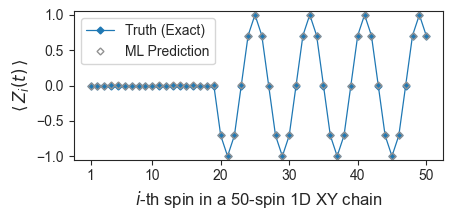

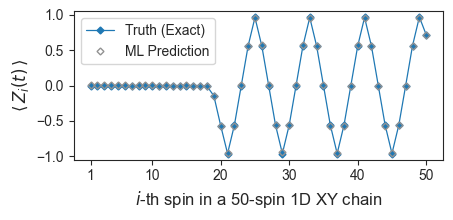

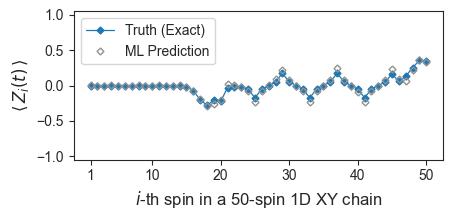

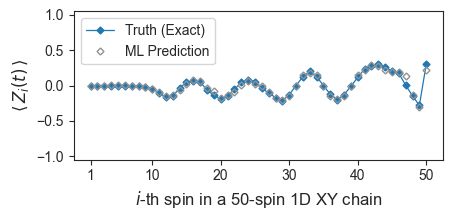

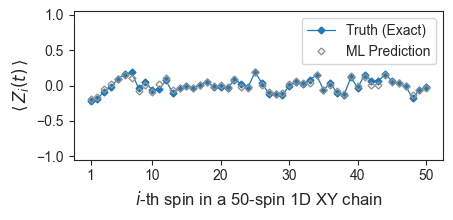

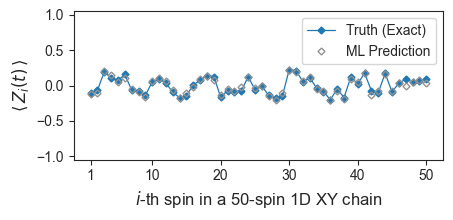

In [ ]:
# Visualize Oscillating state

N = 50

scale = 4.0
oscillating_len = 32
entangled_len = N - oscillating_len

def get_feat_vec_W(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len)) / oscillating_len
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len)) / oscillating_len
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [-5.55112e-16,-6.66134e-16,-3.33067e-16,-6.66134e-16,0,-3.33067e-16,-1.11022e-16,-1.11022e-16,-4.44089e-16,-1.11022e-16,-1.11022e-16,-1.11022e-16,-4.44089e-16,-3.33067e-16,-1.11022e-16,-4.44089e-16,-3.33067e-16,-3.33067e-16,-6.66134e-16,-0.707107,-1,-0.707107,-3.33067e-16,0.707107,1,0.707107,-6.66134e-16,-0.707107,-1,-0.707107,-4.44089e-16,0.707107,1,0.707107,-3.33067e-16,-0.707107,-1,-0.707107,-2.77556e-15,0.707107,1,0.707107,-1.11022e-15,-0.707107,-1,-0.707107,-2.66454e-15,0.707107,1,0.707107,0,-5.55112e-16,-1.22125e-15,-9.99201e-16,0,-3.33067e-16,2.22045e-16,0,-2.10942e-15,-1.77636e-15,1.33227e-15,-5.10703e-15,-1.5925e-12,-3.11422e-10,-4.44776e-08,-4.38862e-06,-0.000275565,-0.00963552,-0.147044,-0.56874,-0.96253,-0.559109,-4.16168e-08,0.559104,0.962255,0.559104,1.33227e-15,-0.559104,-0.962255,-0.559104,-2.01598e-09,0.559104,0.962255,0.559104,-2.01598e-09,-0.559104,-0.962255,-0.559104,3.33067e-15,0.559104,0.962255,0.559104,2.74466e-09,-0.559105,-0.962256,-0.559161,-0.000999399,0.562674,0.968682,0.717039,2.66454e-15,1.55431e-15,-8.21565e-15,-4.77396e-15,1.77636e-15,-1.64313e-14,-7.62834e-13,-2.86574e-11,-9.83163e-10,-2.81194e-08,-6.57331e-07,-1.22692e-05,-0.000177372,-0.00190871,-0.0144726,-0.0713878,-0.202568,-0.277234,-0.210429,-0.224771,-0.0298034,-0.0189252,-0.0144726,-0.0543713,-0.172942,-0.0524749,-6.57372e-07,0.0524626,0.172765,0.0524626,1.60704e-09,-0.0524626,-0.172765,-0.0524626,1.60771e-09,0.0524626,0.172765,0.0524626,-1.26962e-08,-0.0524629,-0.17277,-0.0525289,-0.000621166,0.0487576,0.162028,0.059554,0.128932,0.251019,0.354465,0.34189,-1.64891e-09,-1.80879e-08,-2.03576e-07,-1.98558e-06,-1.67752e-05,-0.000121095,-0.000735011,-0.00367672,-0.0147676,-0.0459711,-0.10537,-0.163749,-0.146579,-0.0407221,0.0427528,0.0699782,0.0522136,-0.0655041,-0.137071,-0.190526,-0.148734,-0.0550436,0.0427527,0.0842996,0.0543686,-0.0387276,-0.10537,-0.170993,-0.215715,-0.128698,-0.000735046,0.124901,0.20093,0.125012,-5.35602e-05,-0.12533,-0.202373,-0.129992,-0.0115816,0.114316,0.23493,0.28248,0.307373,0.260138,0.204349,0.172876,0.00395937,-0.145266,-0.282008,0.297803,-0.214572,-0.184999,-0.0858761,-0.0189614,0.0970766,0.159462,0.184308,-0.0371108,0.0431076,-0.0620992,-0.0533646,0.0711563,-0.105234,-0.0412968,-0.00540601,-0.0321334,0.00893819,0.0564909,-0.0228622,-0.0270342,-0.0390996,0.0786328,0.0274031,-0.0230434,0.188251,0.0373823,-0.114784,-0.118867,-0.135593,-0.00545273,0.0490424,0.0261038,0.0789864,0.149492,-0.0646498,0.0359345,-0.106258,-0.136215,0.117361,-0.0348563,0.152954,0.0624063,0.0612586,0.158723,0.0652991,0.0293106,-0.00661968,-0.178976,-0.0625079,-0.0212084,-0.107264,-0.0704725,0.193965,0.108294,0.0717049,0.156469,-0.0648497,-0.072299,-0.139204,0.0490899,0.0910658,0.0349663,-0.0954868,-0.172838,-0.141793,0.00729624,0.0761089,0.139629,0.126779,-0.165521,-0.0712546,-0.0862275,-0.077053,0.123855,-0.057867,-0.00401261,-0.139977,-0.171911,-0.152037,0.225867,0.210818,0.0540612,0.112161,-0.0380994,-0.084963,-0.202104,-0.0479781,-0.171457,0.122403,0.0217878,0.175638,-0.0748639,-0.102267,0.172358,-0.0882058,0.0305625,0.0908711,0.0497088,0.0588678,0.0956785,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.05, 1.05])

    plt.tight_layout()
    plt.savefig('Entangled-4-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

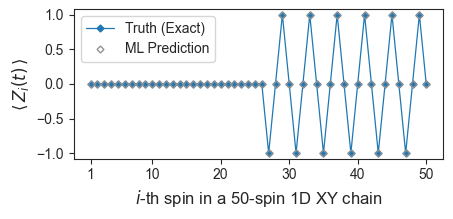

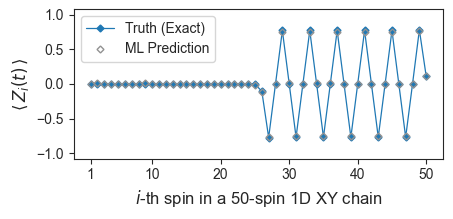

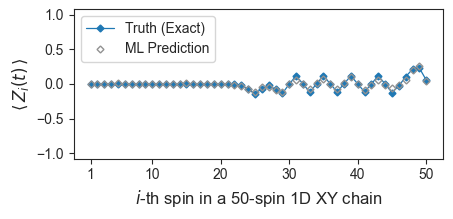

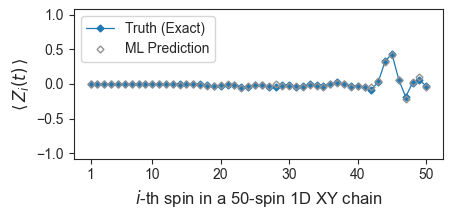

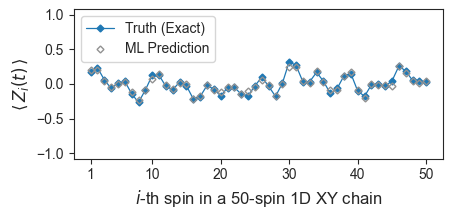

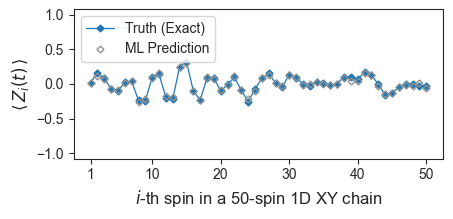

In [ ]:
# Visualize Oscillating state

N = 50

scale = 0.25
oscillating_len = 25
entangled_len = N - oscillating_len

def get_feat_vec_W(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len))
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len))
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [0,-1.11022e-16,2.22045e-16,-1.11022e-16,6.66134e-16,2.22045e-16,4.44089e-16,4.44089e-16,0,4.44089e-16,4.44089e-16,4.44089e-16,0,2.22045e-16,4.44089e-16,0,2.22045e-16,2.22045e-16,-4.44089e-16,0,4.44089e-16,0,4.44089e-16,2.22045e-16,2.22045e-16,6.66134e-16,-1,-2.22045e-16,1,4.44089e-16,-1,-4.44089e-16,1,2.22045e-16,-1,-2.33147e-15,1,-8.88178e-16,-1,-2.66454e-15,1,-3.33067e-16,-1,-2.88658e-15,1,2.22045e-16,-1,-2.33147e-15,1,0,6.66134e-16,0,-6.66134e-16,-4.44089e-16,6.66134e-16,2.22045e-16,6.66134e-16,4.44089e-16,-1.55431e-15,-9.99201e-16,1.77636e-15,1.55431e-15,-7.77156e-16,-7.77156e-16,0,-1.22125e-15,6.66134e-16,1.77636e-15,2.66454e-15,-3.14748e-13,-6.3195e-11,-1.05254e-08,-1.24763e-06,-9.81398e-05,-0.0045927,-0.105622,-0.774579,-9.81411e-05,0.769985,-1.05219e-08,-0.769987,1.35209e-09,0.769987,1.35238e-09,-0.769987,2.22045e-15,0.769987,-1.35238e-09,-0.769987,-1.35239e-09,0.769987,-7.99361e-15,-0.769987,1.147e-09,0.769987,-2.37629e-06,-0.770101,-0.00201803,0.779289,0.107839,3.33067e-15,1.9984e-15,-7.77156e-15,-3.33067e-15,4.44089e-15,-8.88178e-16,1.9984e-15,4.88498e-15,-8.65974e-15,-7.88258e-15,9.54792e-15,7.99361e-15,-1.22125e-15,-6.55032e-15,-3.15847e-12,-1.15585e-10,-3.68859e-09,-9.51021e-08,-1.98227e-06,-3.2461e-05,-0.000403052,-0.00361448,-0.0218106,-0.079066,-0.139189,-0.0699091,-0.022901,-0.079066,-0.138098,-0.00361448,0.115885,-3.24485e-05,-0.11629,-8.31988e-08,0.116288,-1.17724e-10,-0.116288,-1.19193e-08,0.116288,-3.2007e-08,-0.116288,-8.65716e-06,0.116165,-0.00125065,-0.124702,-0.0301418,0.102946,0.211788,0.2284,0.0549484,2.22045e-16,0,-5.10703e-15,-2.5091e-14,6.66134e-16,-4.29434e-13,-6.75471e-12,-1.01429e-10,-1.41485e-09,-1.66839e-08,-1.73902e-07,-1.57113e-06,-1.21947e-05,-8.00841e-05,-0.000436652,-0.00192916,-0.00668157,-0.0173003,-0.0311014,-0.0342591,-0.0198314,-0.0173505,-0.0420583,-0.0419752,-0.0202404,-0.0225374,-0.0421339,-0.0419752,-0.0201647,-0.0173504,-0.041725,-0.0342592,-0.00920796,-0.0173018,-0.0285877,-0.00202041,0.020899,-0.00288813,-0.0331993,-0.0346213,-0.0519068,-0.0824906,0.0274971,0.326942,0.432659,0.0577022,-0.187023,0.0133466,0.0532551,-0.0296511,0.167654,0.235669,0.059428,-0.0647698,0.00977301,0.0359311,-0.142181,-0.268125,-0.08796,0.12132,0.123859,-0.0365826,-0.0825699,0.0243864,-0.0286014,-0.217735,-0.182816,-0.0233282,-0.0754973,-0.174467,-0.0535967,-0.0515959,-0.148926,-0.169623,-0.0281208,0.0987317,-0.0348927,-0.180714,0.0084423,0.319679,0.266015,0.0292598,0.0332248,0.16749,0.0365815,-0.137161,-0.0667869,0.118105,0.148816,-0.103928,-0.179366,-0.0127684,-0.00616234,-0.0335855,0.0411815,0.253788,0.18819,0.0495114,0.0343125,0.0205118,0.0190869,0.158465,0.0807447,-0.0769012,-0.104517,0.0260456,0.0361047,-0.23948,-0.242446,0.0959721,0.142571,-0.201348,-0.216818,0.245565,0.317963,-0.102833,-0.232337,0.08118,0.084799,-0.105552,-0.00880639,0.0923163,-0.089633,-0.2577,-0.0768566,0.0812138,0.150611,0.0129071,-0.0417149,0.134226,0.0912652,-0.00312032,-0.0284457,0.0284919,0.0180958,-0.0224571,0.00262732,0.103439,0.0929488,0.0665141,0.16849,0.127639,-0.00581823,-0.160224,-0.136392,-0.0476056,0.00417718,-0.00822495,-0.0256998,-0.0285305,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.08, 1.08])

    plt.tight_layout()
    plt.savefig('Entangled-8-allZ-{}.pdf'.format(i), dpi=900)
    